<h1>ID5059: Group Project</h1>

The task is as follows:
<ul>
<li>Develop classifier models that predict outcome dead(D), alive with transplant(CL), alive(C) of patients with cirrhosis</li>
    <ul>
    <li>comment on strengths and weaknesses of the models</li>
    </ul>
</ul>

Data is found at:
<ul>
<li>Kaggle: Playground Series - Season 3, Episode 26 (www.kaggle.com/competitions/playground-series-s3e26/overview)
</ul>


Deliverables are:
<ul>
<li>explore the structure of the data and correlations between features</li>
<li>assess three imputation methods</li>
<li>assess two methods of tackling unbalanced class data</li>
<li>perform any further data cleaning as necessary</li>
<li>develop and assess a range of classifier models</li>
<li>report your findings for an (imaginary) client</li>
</ul>

Additional goals to meet are:
<ul>
<li>Assess imputation by removing a small, randomly selected proportion of the data</li>
    <ul>
    <li>Then impute the missing values and compare the results with the original data</li>
    </ul>
</ul>

The Report should include:
<ul>
<li>imputation results</li>
<li>sampling results</li>
<li>justify choice of model</li>
<li>insight into relative importance of features</li>
</ul>

In [47]:
#Preamble imports here
import sys
!{sys.executable} -m pip install numpy pandas matplotlib scikit-learn seaborn xgboost imblearn| grep -v 'already satisfied'
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random 
import scipy
import xgboost as xgb
import warnings 
warnings.filterwarnings('ignore')


from sklearn.model_selection import train_test_split

<h2>1. Data Exploration</h2>

<h3>1.1 Read Data in</h3>

In [48]:
file_path='/Users/musemekonnen/Documents/ID5059/'

full_raw_train_data = pd.read_csv(file_path+"train.csv", index_col=0)
raw_test_data_without_id = pd.read_csv(file_path+"test.csv", index_col=0)
raw_test_data_with_id = pd.read_csv(file_path+"test.csv")

In [49]:
pd.set_option('display.max_columns', None)
full_raw_train_data.head()
print(full_raw_train_data.shape[0], 'observations') 
print(full_raw_train_data.shape[1], 'features')

7905 observations
19 features


<h3>1.2 Description of Features</h3>

In [50]:
full_raw_train_data.columns.values

array(['N_Days', 'Drug', 'Age', 'Sex', 'Ascites', 'Hepatomegaly',
       'Spiders', 'Edema', 'Bilirubin', 'Cholesterol', 'Albumin',
       'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets',
       'Prothrombin', 'Stage', 'Status'], dtype=object)

<img src="Features_def.png" width="700"/>

Image credit: https://www.kaggle.com/datasets/joebeachcapital/cirrhosis-patient-survival-prediction

|Feature|Description and relation to Status|
|---|---|
|ID| unique patient identifier|
|N_Days|number of days from initial survey to either death, transplant or end of study|
|Status| after N_Days is patient alive(C), had a transplant(CL) or dead(D)|
|Drug|Patient given D-penicillamine or a placebo|
|Age| age of patient in days|
|Sex| male(M) or female(F)|
|Ascities|accumulation of fluid in abdomen. Most common complication in cirrhosis. (Y/N)|
|Hepatomegaly|enlargement of liver more than normal(Y/N)|
|Spiders| dilation of blood vessels found under the skin. Indicative of liver disease (Y/N)|
|Edema|swelling caused by fluid collection: Yes if present and not solved by diuretic therapy(Y), S if present and no diuretic therapy or if solved by diuretic therapy(S), No if not present (N) |
|Bilirubin|high Bilirubin levels may indicate liver disease|
|Cholesterol|High Cholesterol may indicate liver isn't working properly|
|Albumin|Low Albumin levels may indicate lever disease|
|Copper|High levels of copper means it gets stored in your liver and damages it|
|Alk_Phos|High levels of Alkaline phosphatase enzyme may indicate liver disease|
|SGOT|type of enzyme, high levels of SGOT indicates liver damage|
|Tryglicerides|type of fat, high Triglycerides may indicate fatty liver disease|
|Platelets|https://pubmed.ncbi.nlm.nih.gov/23742914/ /  https://pubmed.ncbi.nlm.nih.gov/20206174/ Low platelets can sometimes help, sometimes harm|
|Prothrombin|High Prothrombin time may indicate cirrhosis as liver isn't producing enough clotting factors |
|Stage|severity of liver disease, 1 lowest/ 4 highest|


In [51]:
unique_counts = pd.DataFrame.from_records([(col, full_raw_train_data[col].nunique(), full_raw_train_data[col].dtypes) for col in full_raw_train_data.columns], columns=['Column_Name', 'unique_values', 'current data type']).sort_values(by=['unique_values'])    
unique_counts

Column_Name  unique_values current data type
1            Drug              2            object
3             Sex              2            object
4         Ascites              2            object
5    Hepatomegaly              2            object
6         Spiders              2            object
18         Status              3            object
7           Edema              3            object
17          Stage              4           float64
16    Prothrombin             49           float64
8       Bilirubin            111           float64
14  Tryglicerides            154           float64
10        Albumin            160           float64
11         Copper            171           float64
13           SGOT            206           float64
9     Cholesterol            226           float64
15      Platelets            227           float64
12       Alk_Phos            364           float64
2             Age            391             int64
0          N_Days            461             int64

In [52]:
full_raw_train_data.describe()

N_Days           Age    Bilirubin  Cholesterol      Albumin  \
count  7905.000000   7905.000000  7905.000000  7905.000000  7905.000000   
mean   2030.173308  18373.146490     2.594485   350.561923     3.548323   
std    1094.233744   3679.958739     3.812960   195.379344     0.346171   
min      41.000000   9598.000000     0.300000   120.000000     1.960000   
25%    1230.000000  15574.000000     0.700000   248.000000     3.350000   
50%    1831.000000  18713.000000     1.100000   298.000000     3.580000   
75%    2689.000000  20684.000000     3.000000   390.000000     3.770000   
max    4795.000000  28650.000000    28.000000  1775.000000     4.640000   

            Copper      Alk_Phos         SGOT  Tryglicerides    Platelets  \
count  7905.000000   7905.000000  7905.000000    7905.000000  7905.000000   
mean     83.902846   1816.745250   114.604602     115.340164   265.228969   
std      75.899266   1903.750657    48.790945      52.530402    87.465579   
min       4.000000    289.000000    26.350000      33.000000    62.000000   
25%      39.000000    834.000000    75.950000      84.000000   211.000000   
50%      63.000000   1181.000000   108.500000     104.000000   265.000000   
75%     102.000000   1857.000000   137.950000     139.000000   316.000000   
max     588.000000  13862.400000   457.250000     598.000000   563.000000   

       Prothrombin        Stage  
count  7905.000000  7905.000000  
mean     10.629462     3.032511  
std       0.781735     0.866511  
min       9.000000     1.000000  
25%      10.000000     2.000000  
50%      10.600000     3.000000  
75%      11.000000     4.000000  
max      18.000000     4.000000

<ul>
<li>Drug, Sex, Acities, Hepatomegaly, Spiders can be boolean(Y/N => 1 or 0) </li>
    
<li> Status, Edema, Stage can be categorial </li>
    <ul>
        <li>The target "Status" comes with three unique values (C, CL, D) that need to be label encoded</li>
    </ul>
<li>Prothrombin, Bilirubin, Tryglicerides, Albumin, Copper, SGOT, Cholesterol, Platelets, Alk_Phos, Age, N_Days are numerical data</li>
    <ul>
        <li>out of these Age, N_Days, Cholesterol, Copper, Tryglicerides, Platelets are integers and the rest are floats</li>
    </ul> 
</ul>

<h3>1.3 Data Types</h3>

In [53]:
integer_column=['N_Days','Age','Cholesterol','Copper','Tryglicerides','Platelets','Stage']
categorical_column=['Drug','Sex','Ascites','Hepatomegaly','Spiders','Edema', 'Status']
float_column=['Bilirubin','Albumin','Alk_Phos','SGOT','Prothrombin']


# Switch data types
for i in categorical_column:
    full_raw_train_data[i] = pd.Categorical(full_raw_train_data[i])

for i in integer_column:
    full_raw_train_data[i] = full_raw_train_data[i].astype('int64')

for i in float_column:
   full_raw_train_data[i] = full_raw_train_data[i].astype('float')

<h2>2. Data Visualisation</h2>

<h3>2.1 Order</h3>

In [54]:
numerical_feature_index=np.concatenate((np.where(full_raw_train_data.dtypes=='int64')[0],
                                        np.where(full_raw_train_data.dtypes=='float64')[0]), axis=0)


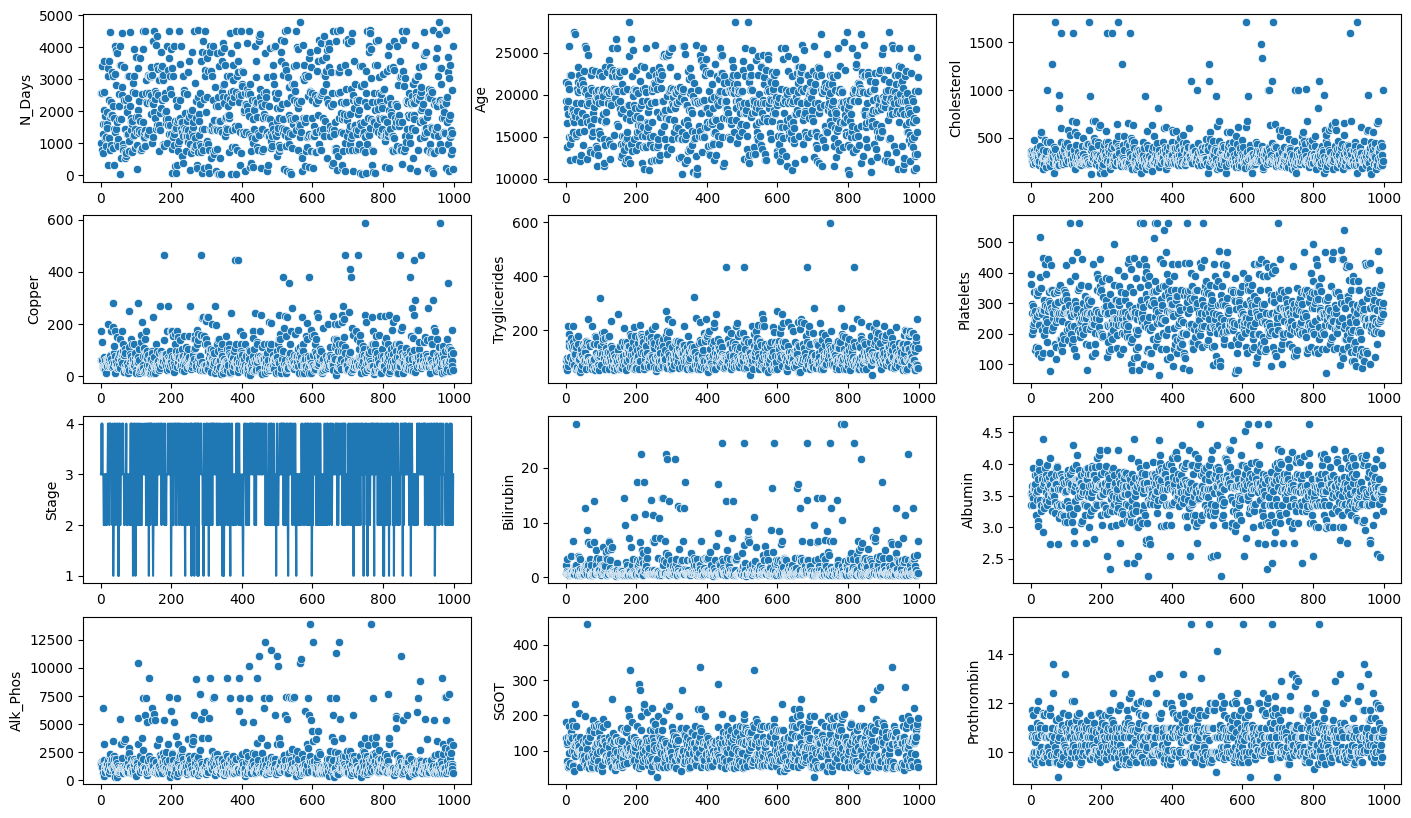

In [55]:
#plots first 1000 points of numerical data to see if the list has been sorted.
#No underlying order visible
figures_y=4 
figures_x=3
feature=0
num_of_points=1000 
fig, axs=plt.subplots(figures_y,figures_x, figsize=(17,10))

for i in range(0,figures_y):
    for j in range(0,figures_x):
        if num_of_points> full_raw_train_data.shape[0]: # can't go above max number of observations
            num_of_points=full_raw_train_data.shape[0]  
        if full_raw_train_data.columns[numerical_feature_index[feature]] != 'Stage':  
            sns.scatterplot(x=list(range((num_of_points))), y=full_raw_train_data.loc[:,full_raw_train_data.columns[numerical_feature_index[feature]]][0:num_of_points],ax=axs[i,j])
        else:    
            sns.lineplot(x=list(range((num_of_points))), y=full_raw_train_data.loc[:,full_raw_train_data.columns[numerical_feature_index[feature]]][0:num_of_points],ax=axs[i,j])
        feature+=1




<h3>2.2 Numerical Features</h3>

<h4>2.2.1 Distribution of single Numerical Features</h4>

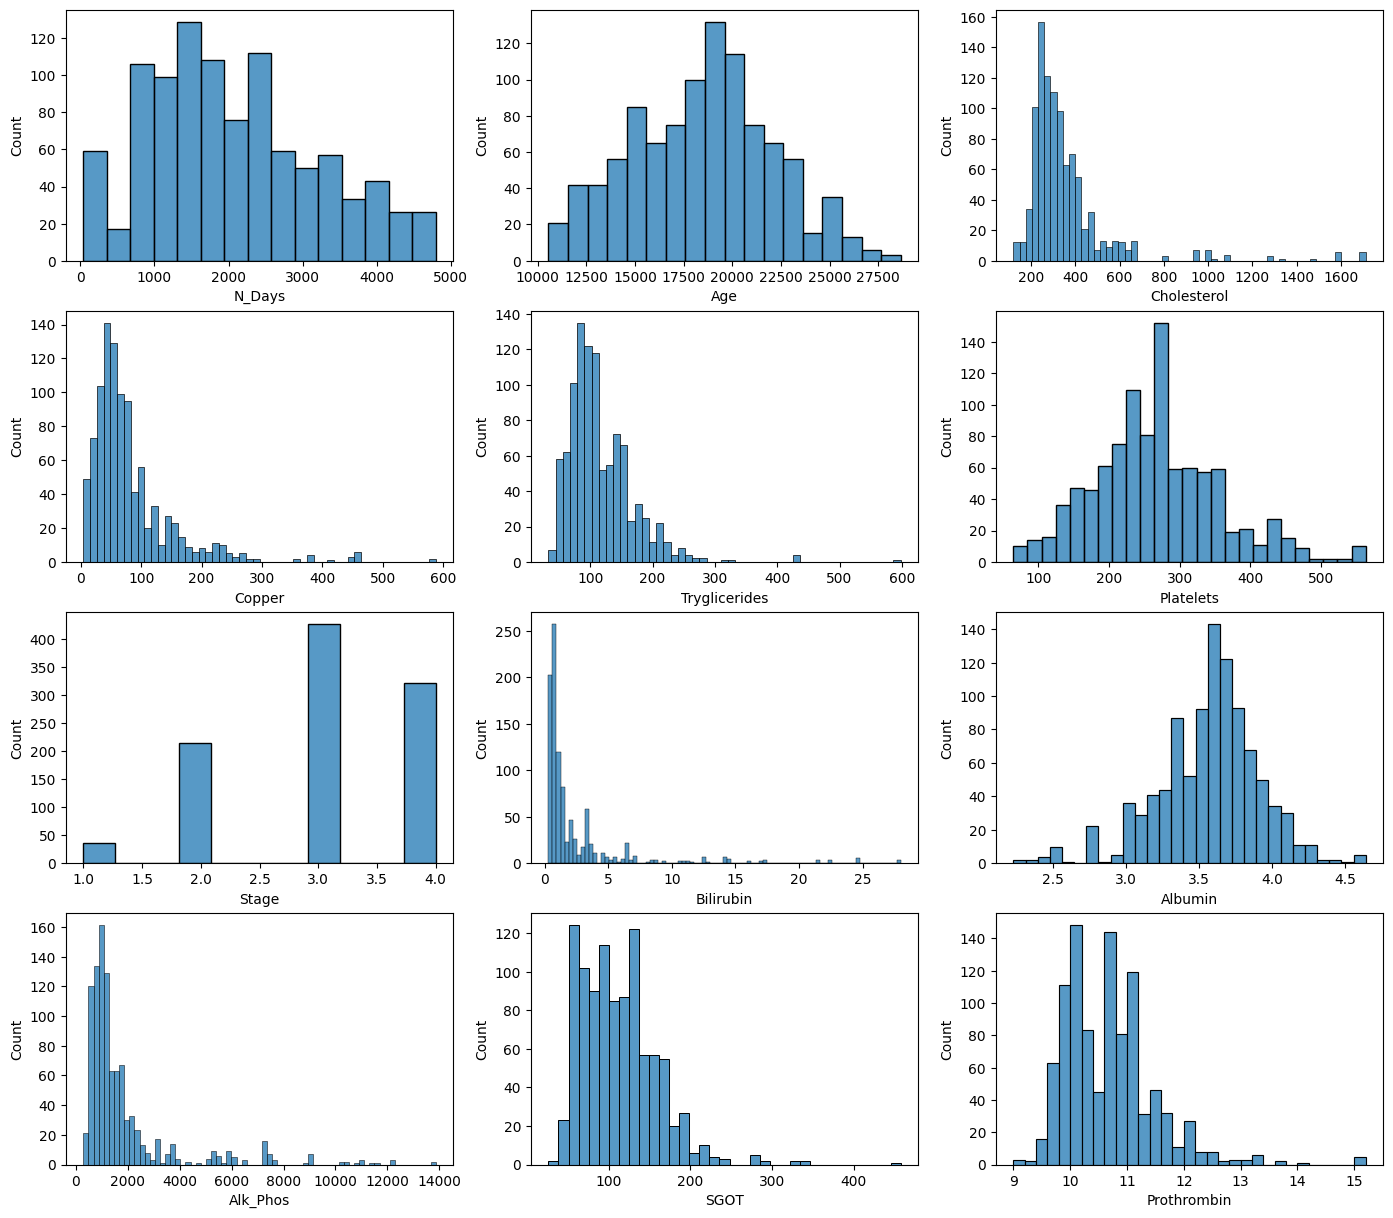

In [56]:
#Histogram of numerical features showing total count.
# Useful for looking at general distribution such as when looking at whether to impute with mean or median
# However when looking for trends between status and numerical feature a better comparison is the fraction of each patient with a certain label as shown in the following cells
figures_y=4 
figures_x=3
feature=0
fig, axs=plt.subplots(figures_y,figures_x, figsize=(17,15))

for i in range(0,figures_y):
    for j in range(0,figures_x):
        sns.histplot(full_raw_train_data.loc[:,full_raw_train_data.columns[numerical_feature_index[feature]]][0:num_of_points],ax=axs[i,j])
        feature+=1


In [57]:
def fractional_hist_plot(feature, num_bins):
    """
    Function that plots histograms for continuous features. Also plots second line graph showing what fraction of that feature is alive/ alive w transplant/ dead. 
    Takes in parameter 'feature' of type string. 
    Takes in parameter 'num_bins' of type integer (or string if that string is 'auto')
    """
    fig, axs=plt.subplots(2, figsize=(10,7))

    from matplotlib.ticker import AutoMinorLocator
    axs[0].xaxis.set_minor_locator(AutoMinorLocator(4))
    axs[0].yaxis.set_minor_locator(AutoMinorLocator(4))
    axs[1].xaxis.set_minor_locator(AutoMinorLocator(4))
    axs[1].yaxis.set_minor_locator(AutoMinorLocator(4))    
    

    plt.gca().tick_params(axis="x", which="minor", direction="in", width=0.7, length=5)

    values_total=axs[0].hist(full_raw_train_data[feature].values, label='Total number \n of patients', bins=num_bins, alpha=0.3, color='k')
    
    values_alive=axs[0].hist(full_raw_train_data.iloc[np.where(full_raw_train_data['Status']=='C')[0]][feature].values, label='Status C patients', bins=values_total[1], alpha=0.3, color='b')
    values_alive_w_transplant=axs[0].hist(full_raw_train_data.iloc[np.where(full_raw_train_data['Status']=='CL')[0]][feature].values, label='Status CL patients', bins=values_total[1] , alpha=0.3,color='orange')
    values_dead=axs[0].hist(full_raw_train_data.iloc[np.where(full_raw_train_data['Status']=='D')[0]][feature].values, label='Status D patinets', bins=values_total[1], alpha=0.3, color='green')

    fractional_alive=values_alive[0]/values_total[0]
    fractional_alive_w_transplant=values_alive_w_transplant[0]/values_total[0]
    fractional_dead=values_dead[0]/values_total[0]

    #---------------adapted from-https://stackoverflow.com/questions/72702939/seaborn-barplot-for-two-datasets-without-overlapping
    ds1 = pd.DataFrame({'bin_values':values_total[1][:-1], 'fractional':fractional_alive})
    ds2 = pd.DataFrame({'bin_values':values_total[1][:-1], 'fractional':fractional_alive_w_transplant})
    ds3 = pd.DataFrame({'bin_values':values_total[1][:-1], 'fractional':fractional_dead})

    ds3['ds'] = 'fraction of patients \n with status D'
    ds2['ds'] = 'fraction of patients \n with status CL'
    ds1['ds'] = 'fraction of patients \n with status C'
    dss = pd.concat([ds1, ds2, ds3], axis=0).reset_index(drop=True)
    plot=sns.lineplot(x='bin_values', y='fractional', hue='ds', data=dss)
    #---------------


    xtick_loc=plot.get_xticks()
    xtick_labels=plot.get_xticklabels()
    plot.set_xticks(ticks= xtick_loc, labels=xtick_labels, rotation=90)


    title_1= 'Number of patients against the'+' '+feature+' values'
    title_2= 'Fraction of patients in each class against the'+' '+feature+' values'

    axs[0].set_title(title_1, fontsize=18)
    axs[1].set_title(title_2, fontsize=14)
    axs[0].legend(loc=(1.01,0.50), fontsize=13)
    axs[1].legend(loc=(1.01,0.40),fontsize=13)

    axs[0].tick_params(axis='both', which='major', labelsize=12)
    axs[1].tick_params(axis='both', which='major', labelsize=12)


    margin=(values_total[1][-1]-values_total[1][0])/len(axs[1].get_xticklabels(which='both'))
    axs[1].set(xlim=(values_total[1][0]-margin, values_total[1][-1]))
    axs[1].set_xlabel(feature, fontsize=12)
    axs[1].set_ylabel('Fraction',fontsize=12)
    


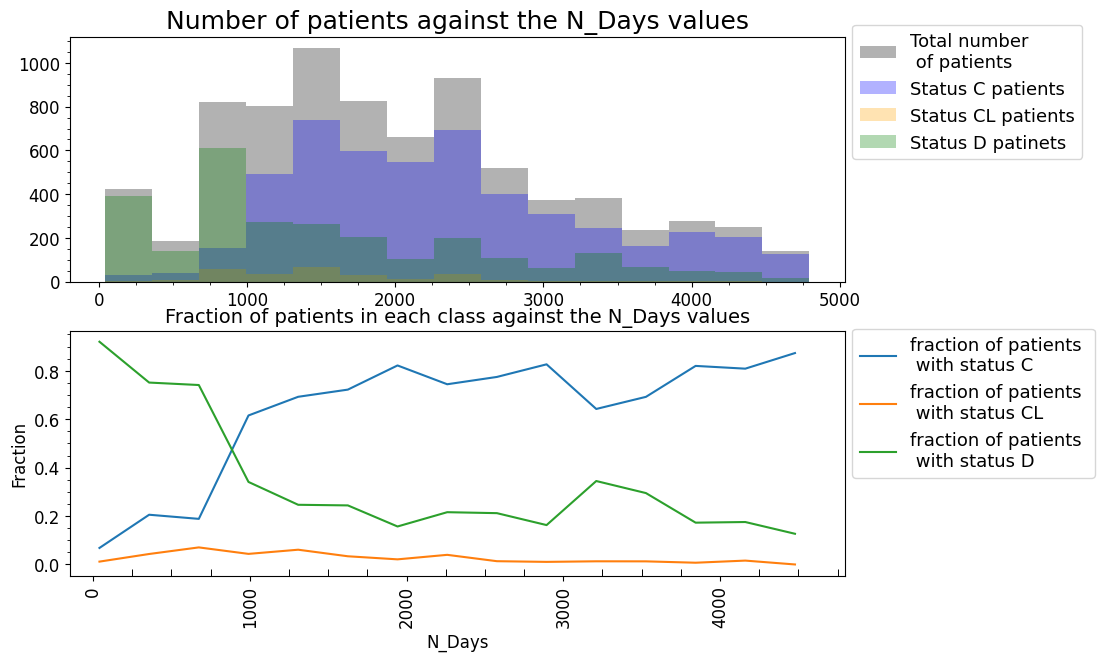

In [58]:
# General distribution: rises quickly, peaks around 1300 and then again 2250/2500 and slowly decreases from there
# Fractional distribution: Patients mostly die within first ~2.5 years. After that likelihood of living rises 
fractional_hist_plot('N_Days', 15)

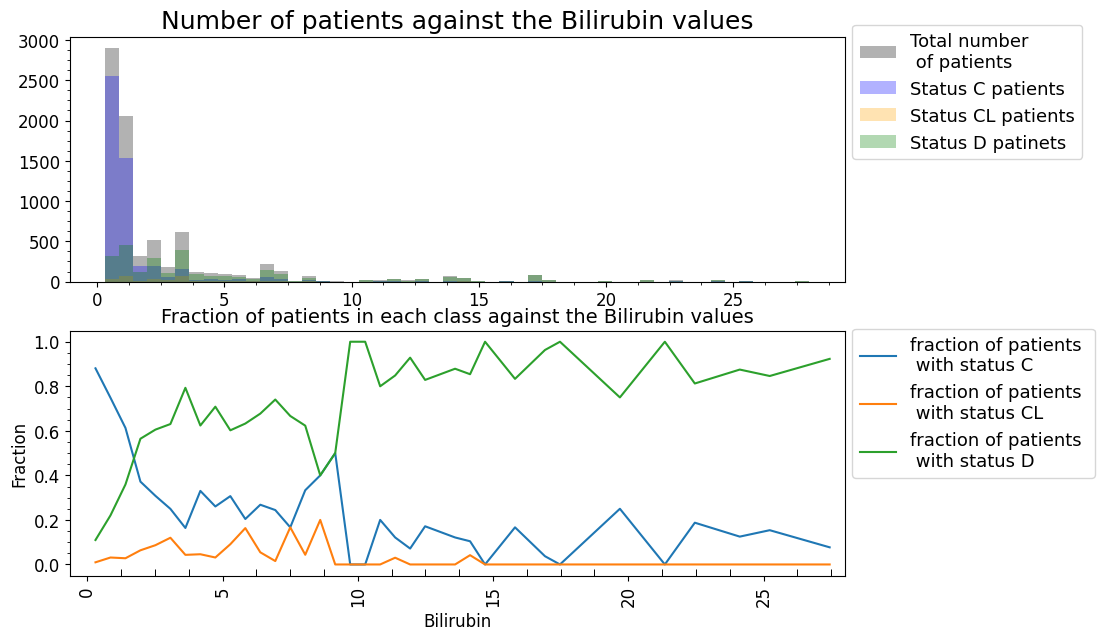

In [59]:
# General Distribution: Peaks at values lower than ~1.25 and decreases rapidly after than with a long tail going out to ~28. Healty levels are ~0.3
# Fractional Distribution: Likelihood of death increasse after ~1.4
fractional_hist_plot('Bilirubin',50)

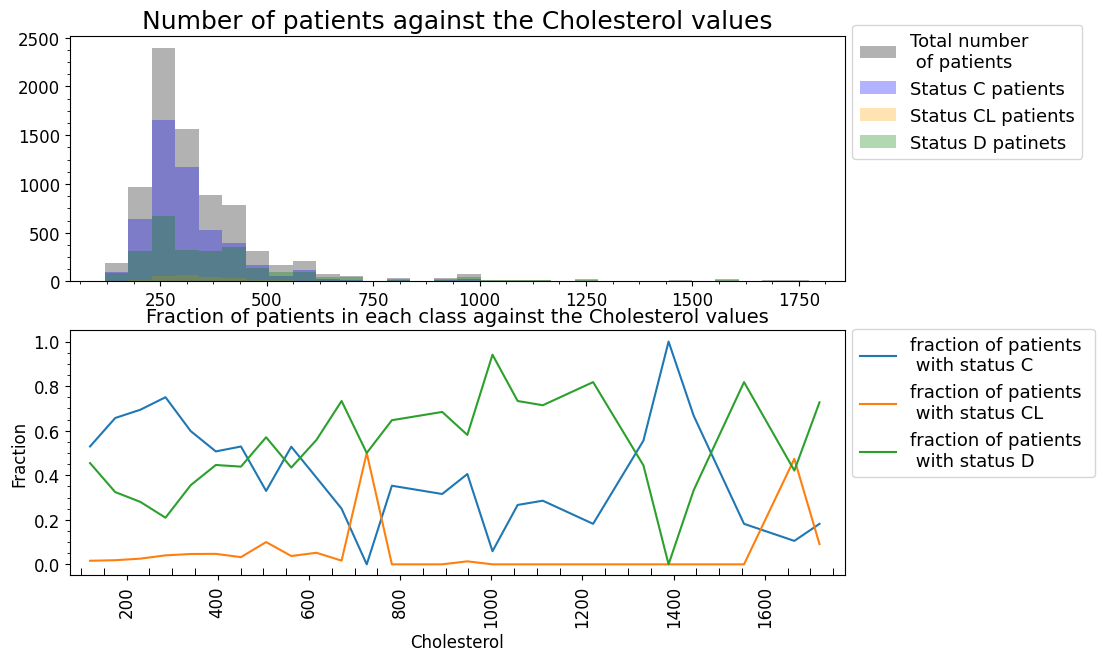

In [60]:
# General Distribution: Peaks around 250 and has long wings that go up to ~1750. 
#https://www.hopkinsmedicine.org/health/treatment-tests-and-therapies/lipid-panel#:~:text=Here%20are%20the%20ranges%20for,200%20to%20239%20mg%2FdL
#Healthy levels are less than 200 mg/dl

# Fractional Distribution: the likelihood of survival is best when levels are around 200, higher or lower values have an increased likelihood of death
fractional_hist_plot('Cholesterol', 30)

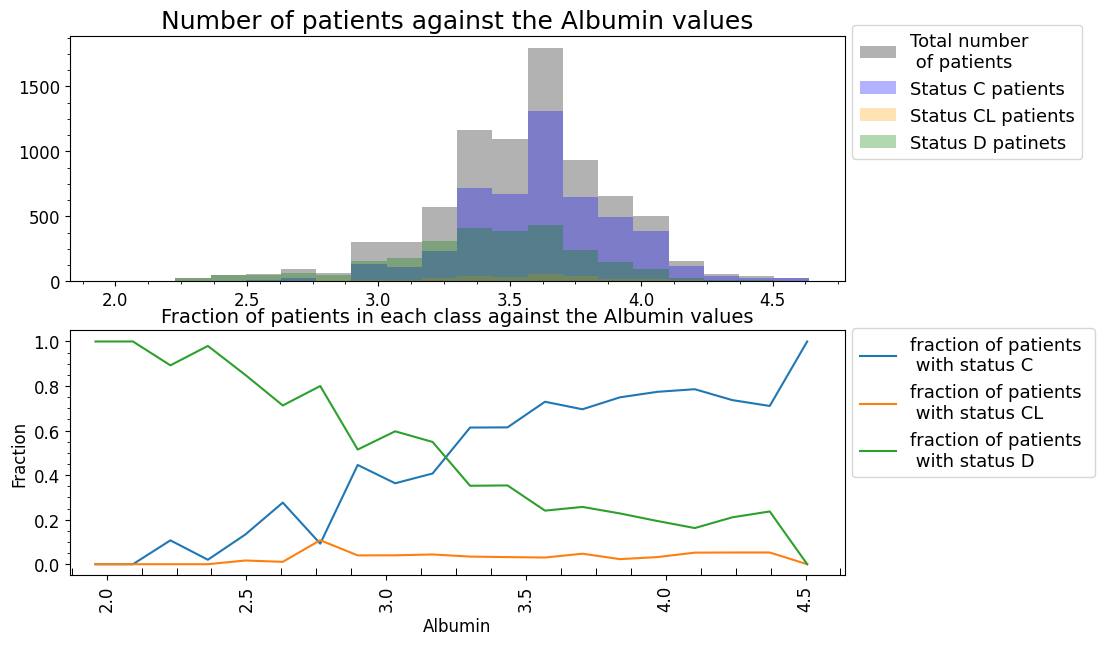

In [61]:
# General Distribution: Peaks 3.625, decays equally both sides  
# Fractional Distribution: likelihood of survial is higher than death after ~3.2
fractional_hist_plot('Albumin', 20)

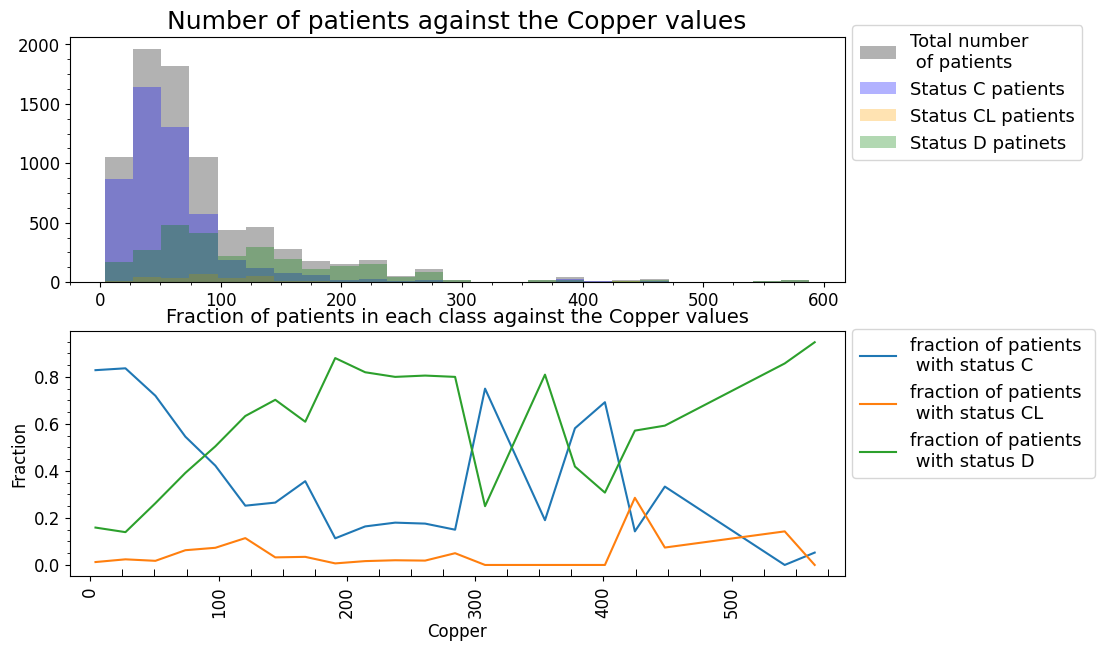

In [62]:
# General Distribution: peaks 25-50 ug/dl 
# Fractional Distribution: Higher copper levels have higher likliehood of death. After 300 difficult to see a trend due to lack of data but looks to level out
fractional_hist_plot('Copper', 25)

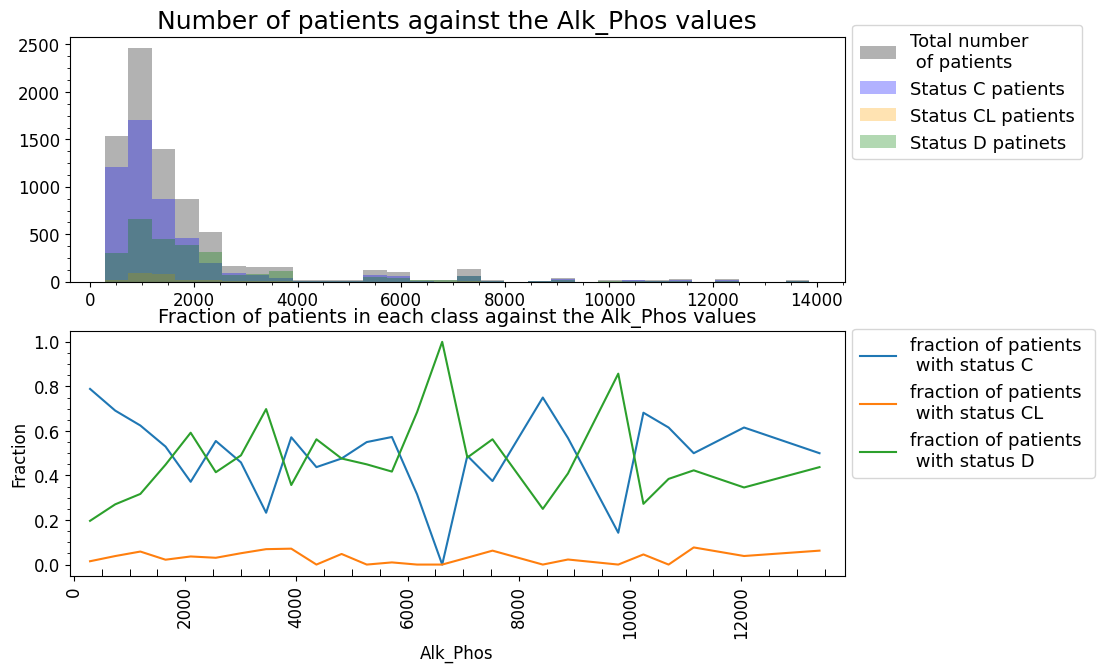

In [63]:
# General Distribution: Peaks at 1000 U/L and quickly falls off, has long wings with valyes going up to 14000
# Fractional Distribution: higher values than 2000 increases likelihood of death
fractional_hist_plot('Alk_Phos', 30)

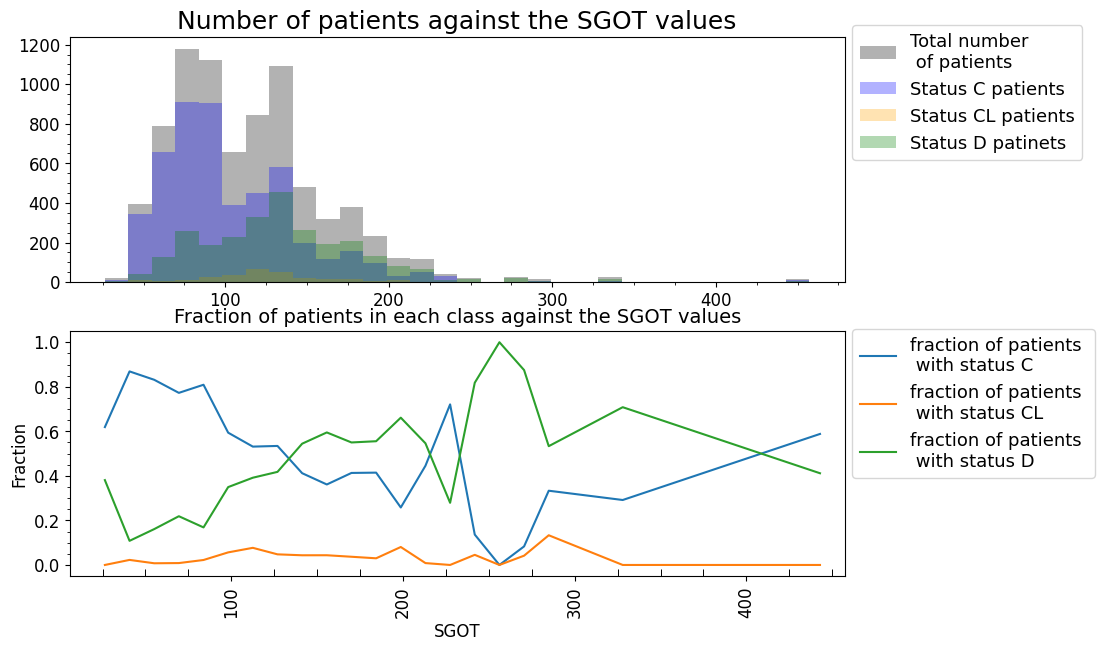

In [64]:
# General Distribution: Peaks around 75 and then again at 125
# Fractional Distribution: levles >141 indicate higher likelihood of death
fractional_hist_plot('SGOT', 30)

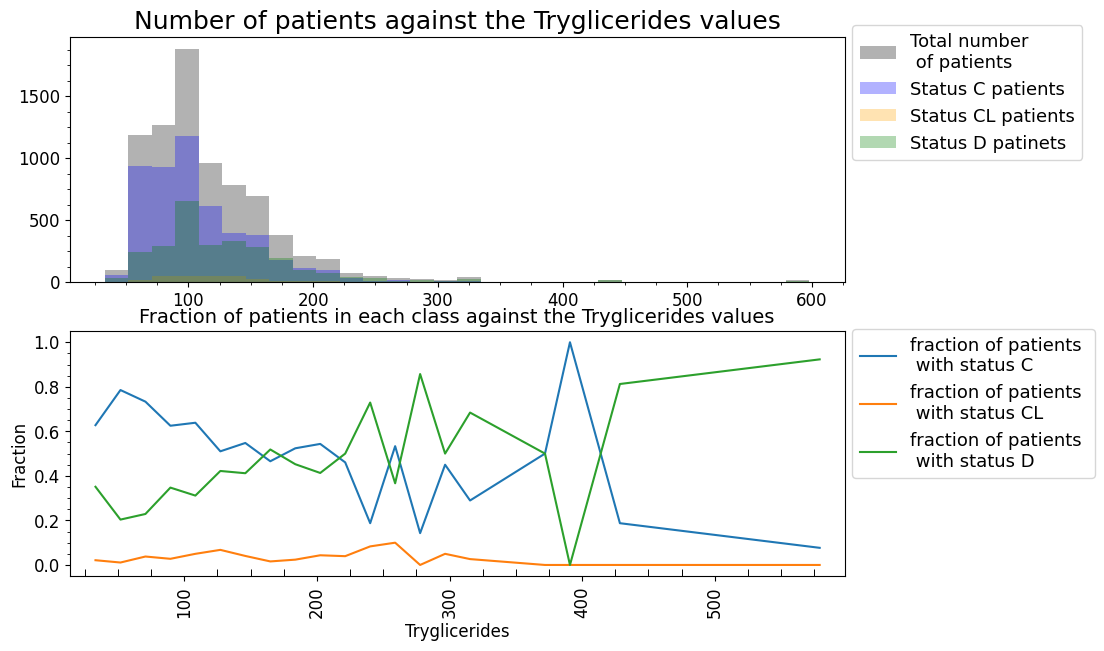

In [65]:
# General Distribution: Peaks at around 100, decreases slowwly with a long wing on the right side
# Fractional Distribution: After 225, likelihood of death is higher than living
fractional_hist_plot('Tryglicerides', 30)

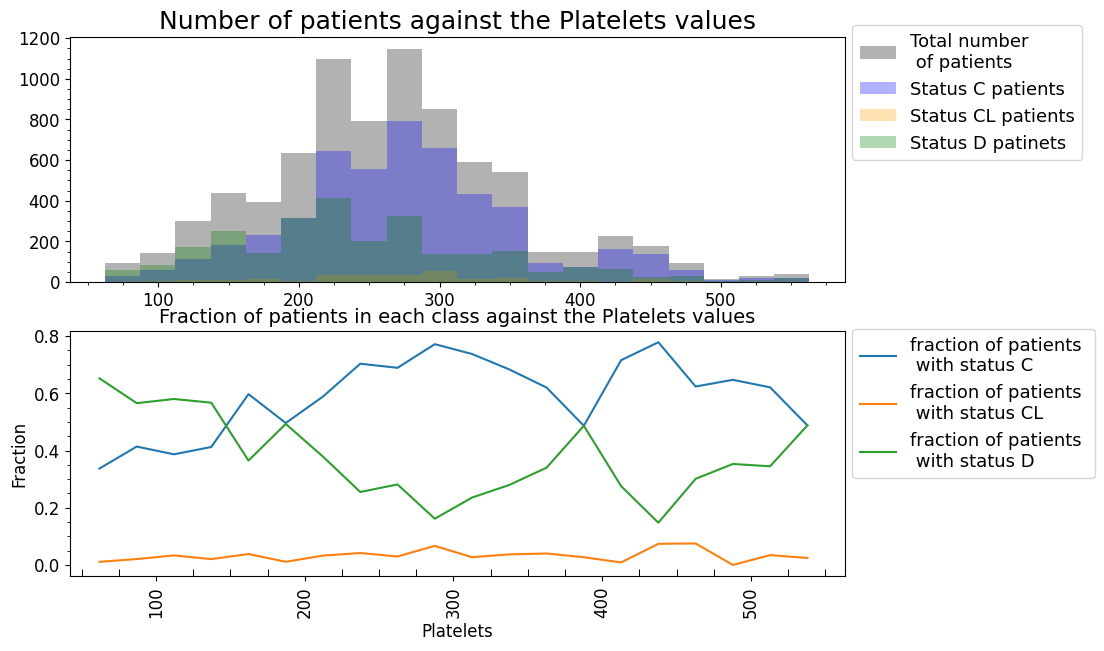

In [66]:
# General Distribution: Peaks twices at 225 and then again 275
# Fractional Distribution: non-linear relationship, fractional alive seems to peak at 300 and then decreases again
fractional_hist_plot('Platelets', 20)

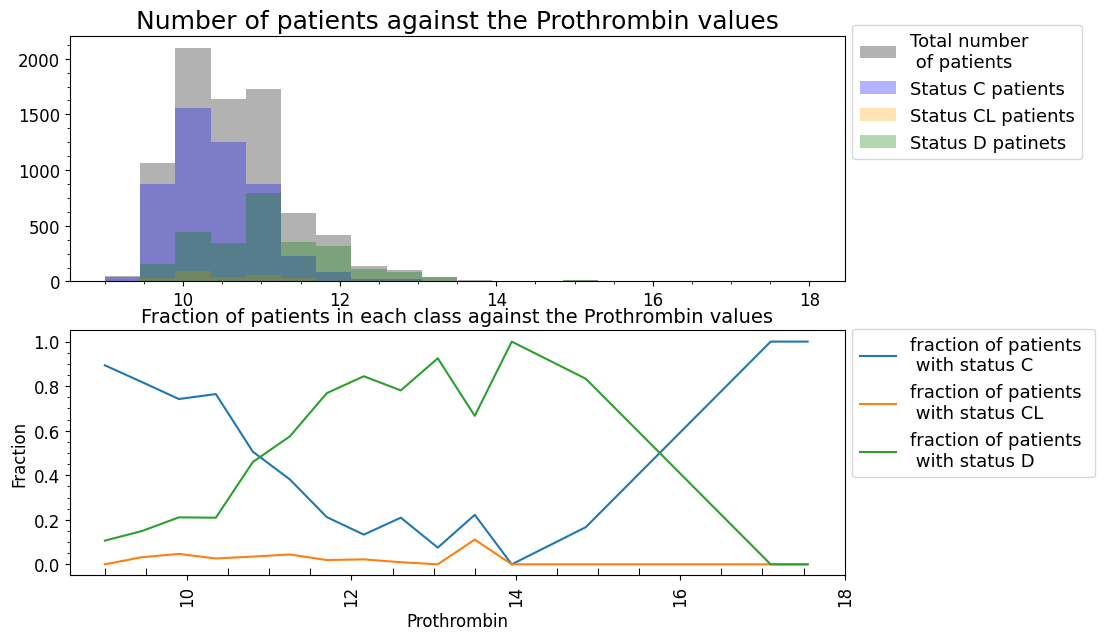

In [67]:
# General Distribution: Peaks at 10s, has a long right tail up to 18
# Fractional Distribution: Up to 13.5s (where we have enough data) ~11 is the crossing point between likelihood of alive and dead
# They do cross again at 16s however this tread is less reliable as there is less data past 13.5s
fractional_hist_plot('Prothrombin', 20)

Status         C        CL         D
Stage                               
1       0.884131  0.017632  0.098237
2       0.782688  0.028450  0.188862
3       0.728830  0.035839  0.235331
4       0.378468  0.039956  0.581576

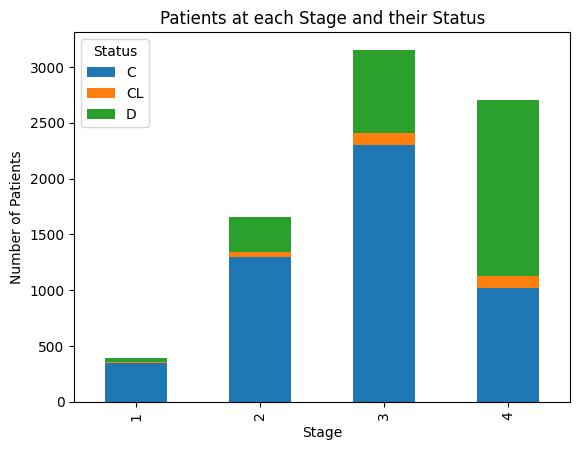

In [68]:
# General distribution: Most patients are in stage 3
# Fractional distribution: Patients at stages 1-3 are more likleiy to survive, patients in stage 4 are more likely to die,
# Patients are slighly more likely to get a transplant in stage 4 than stage 3: 3.9956% vs 3.5839% seen from normalised table below
stacked_bar_df=pd.crosstab(full_raw_train_data['Stage'], full_raw_train_data["Status"])
stacked_bar_df.plot(kind='bar', stacked=True)
plt.ylabel('Number of Patients')
plt.title('Patients at each Stage and their Status')

stacked_bar_df=pd.crosstab(full_raw_train_data['Stage'], full_raw_train_data["Status"], normalize='index')
display(stacked_bar_df)

<h4>2.2.2 Numerical Features VS Status</h4>

In [69]:
train = full_raw_train_data.copy()

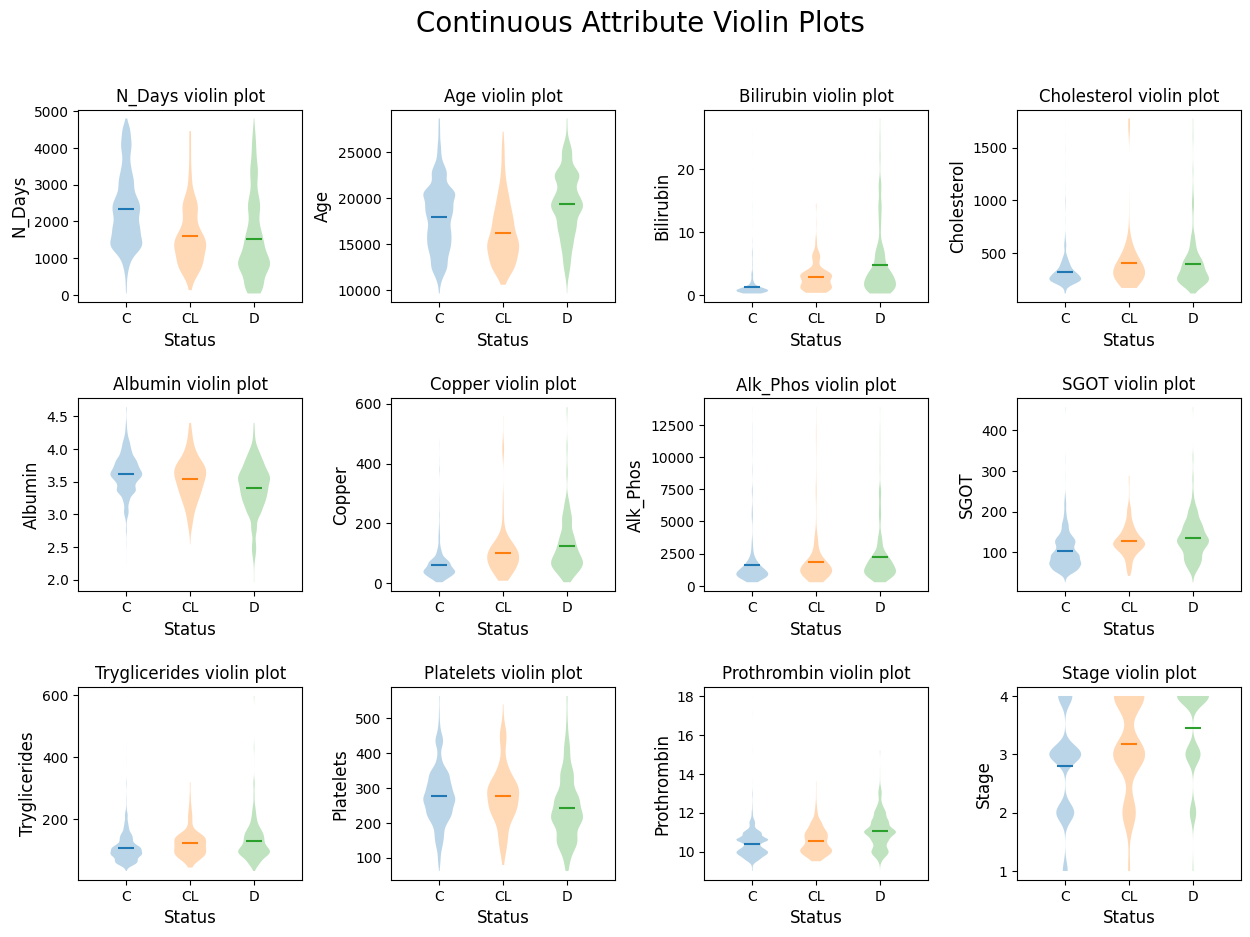

In [70]:
# Quick violin plots for continuous attributes
# List of attributes
var = list(train.columns)
if "id" in var:
    var.remove("id")
if "Status" in var:
    var.remove("Status")
# Create list for each Status
stat = ["C", "CL", "D"]
# Create list for each continuous attribute
cts_var = ["N_Days", "Age", "Bilirubin", "Cholesterol", "Albumin", "Copper", "Alk_Phos", "SGOT",
           "Tryglicerides", "Platelets", "Prothrombin", "Stage"]
# Create list for each dicrete attribute
d_var = ["Drug", "Sex", "Ascites", "Hepatomegaly", "Spiders", "Edema"]
# Function to define x axis labels
def set_axis_style(ax, labels):
    ax.set_xticks(np.arange(1, len(labels) + 1), labels=labels)
    ax.set_xlim(0.25, len(labels) + 0.75)
    ax.set_xlabel("Status", fontsize = 12)
# Create plot space
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(15, 10))
# Create each violin plot
for a in range(len(cts_var)):
    # Define position of plot within plot space
    if a < 4:
        j = 0
        k = a
    elif a < 8:
        j = 1
        k = a - 4
    else:
        j = 2
        k = a - 8
    # Create a violin plot for each status
    for i in range(3):
        axs[j, k].violinplot(train[cts_var[a]][train["Status"] == stat[i]],
                         positions=[i + 1], showmeans=True, showextrema=False)
    axs[j, k].set_title(cts_var[a] + " violin plot")
    axs[j, k].set_ylabel(cts_var[a], fontsize = 12)
    axs[j, k].tick_params(axis='both', labelsize = 10)
    set_axis_style(axs[j, k], stat)
    
fig.suptitle("Continuous Attribute Violin Plots", fontsize=20)
fig.subplots_adjust(wspace = 0.4, hspace = 0.5)


Shows similar trends to fractional plots in section 2.2.1 through the clustering of the plots around the median value.

<h4>2.2.3 Numerical VS Numerical Features</h4>

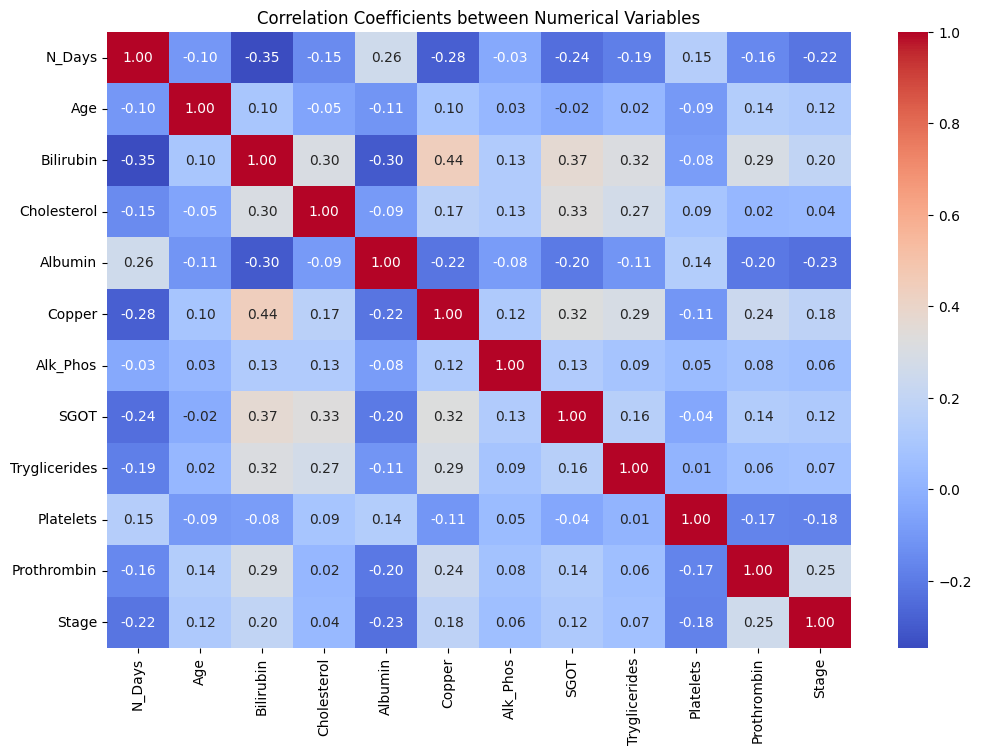

In [71]:
correlation_matrix = full_raw_train_data.select_dtypes(include=['float64', 'int64']).corr()

# Display the correlation matrix as a heatmap using seaborn
plt.figure(figsize=(12, 8))  # You can adjust the size as needed
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Coefficients between Numerical Variables')
plt.show()

Features such as Bilirubin and copper seem to have high correlation with other features. <br>
Features such as platelets seems to be weakly correlating

<h3>2.3 Categorical Features</h3>

<h4>2.3.1 Distribution of single Categorical Features</h4>

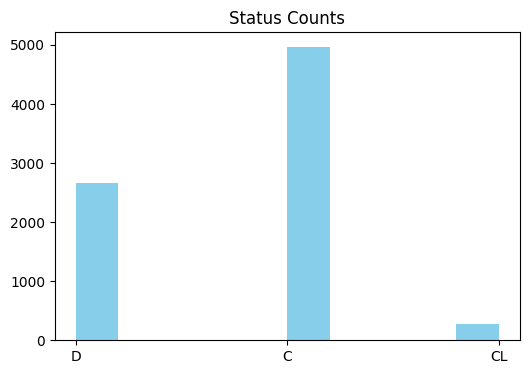

In [72]:
# Status Histogram
full_raw_train_data['Status'].hist(grid=False, figsize=(6, 4),color='skyblue')
plt.title('Status Counts')
# plt.xticks([1,1])
plt.show()


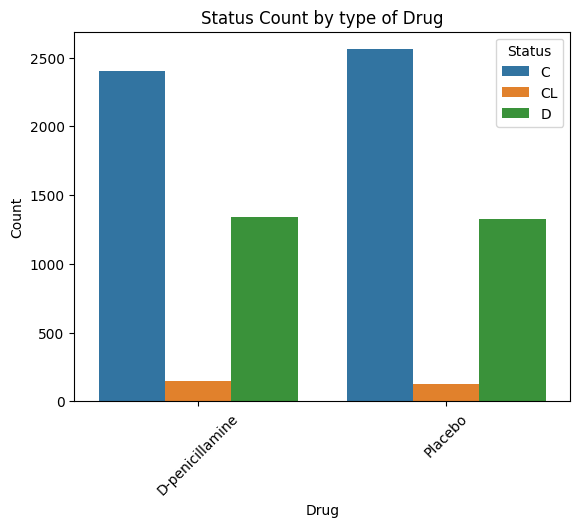

In [73]:
sns.countplot(x='Drug', hue='Status', data=full_raw_train_data)
plt.title('Status Count by type of Drug')
plt.xlabel('Drug')
plt.ylabel('Count')
plt.xticks(rotation=45)  # If the drug name is long, the label can be rotated for better display
plt.show()


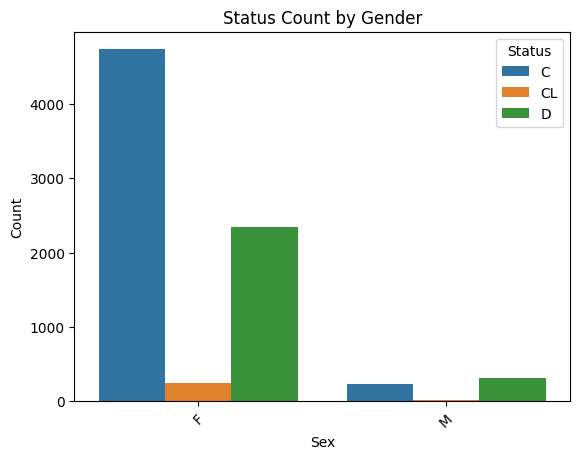

In [74]:
sns.countplot(x='Sex', hue='Status', data=full_raw_train_data)
plt.title('Status Count by Gender')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.xticks(rotation=45)  
plt.show()


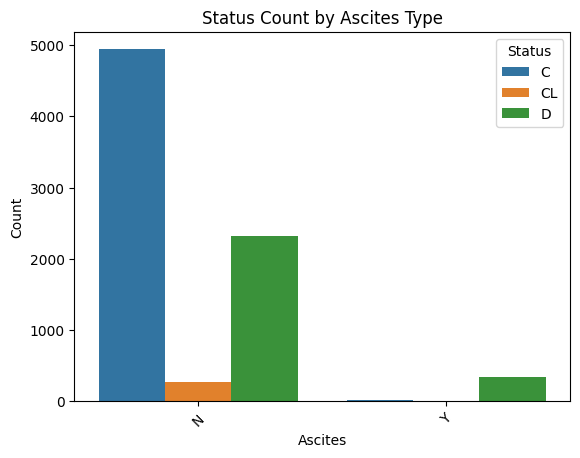

In [75]:
sns.countplot(x='Ascites', hue='Status', data=full_raw_train_data)
plt.title('Status Count by Ascites Type')
plt.xlabel('Ascites')
plt.ylabel('Count')
plt.xticks(rotation=45)  
plt.show()

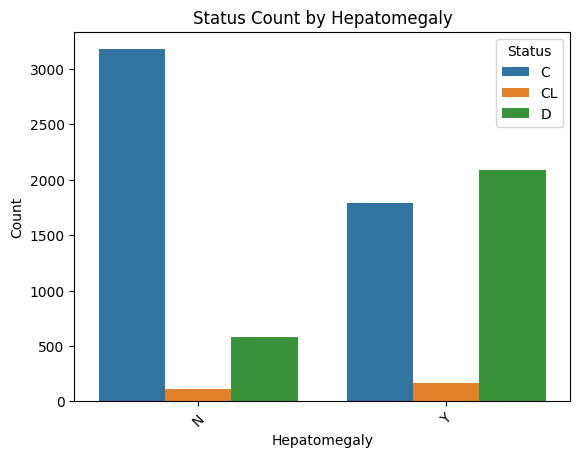

In [76]:
sns.countplot(x='Hepatomegaly', hue='Status', data=full_raw_train_data)
plt.title('Status Count by Hepatomegaly')
plt.xlabel('Hepatomegaly')
plt.ylabel('Count')
plt.xticks(rotation=45)  
plt.show()

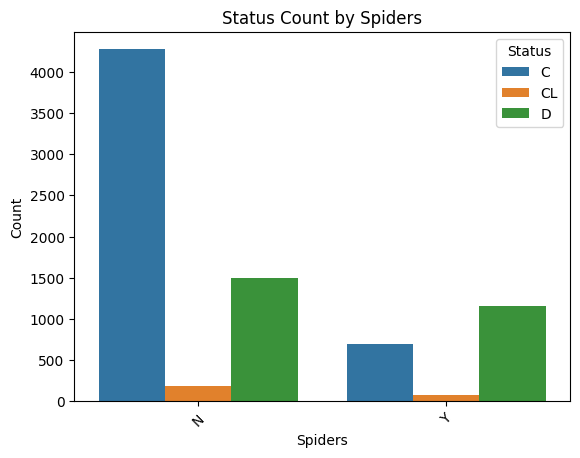

In [77]:
sns.countplot(x='Spiders', hue='Status', data=full_raw_train_data)
plt.title('Status Count by Spiders')
plt.xlabel('Spiders')
plt.ylabel('Count')
plt.xticks(rotation=45)  
plt.show()

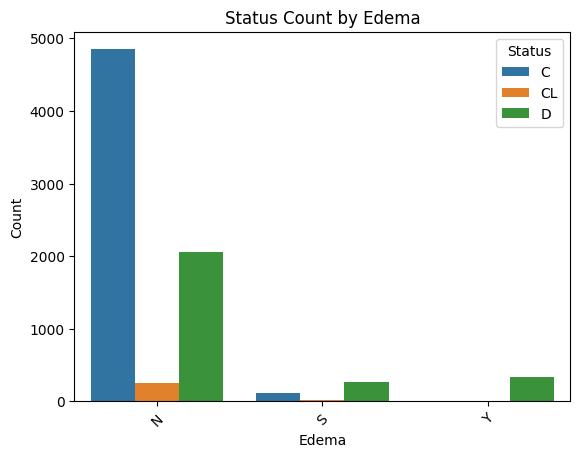

In [78]:
sns.countplot(x='Edema', hue='Status', data=full_raw_train_data)
plt.title('Status Count by Edema')
plt.xlabel('Edema')
plt.ylabel('Count')
plt.xticks(rotation=45)  
plt.show()

<ul>
    <li>Sex, Ascites and Edema are unbalanced</li>
    <li>Drug and Hepatomegaly seem to be the only unbalanced features here</li>
    <li>Spiders is somewhere inbetween</li>
</ul>

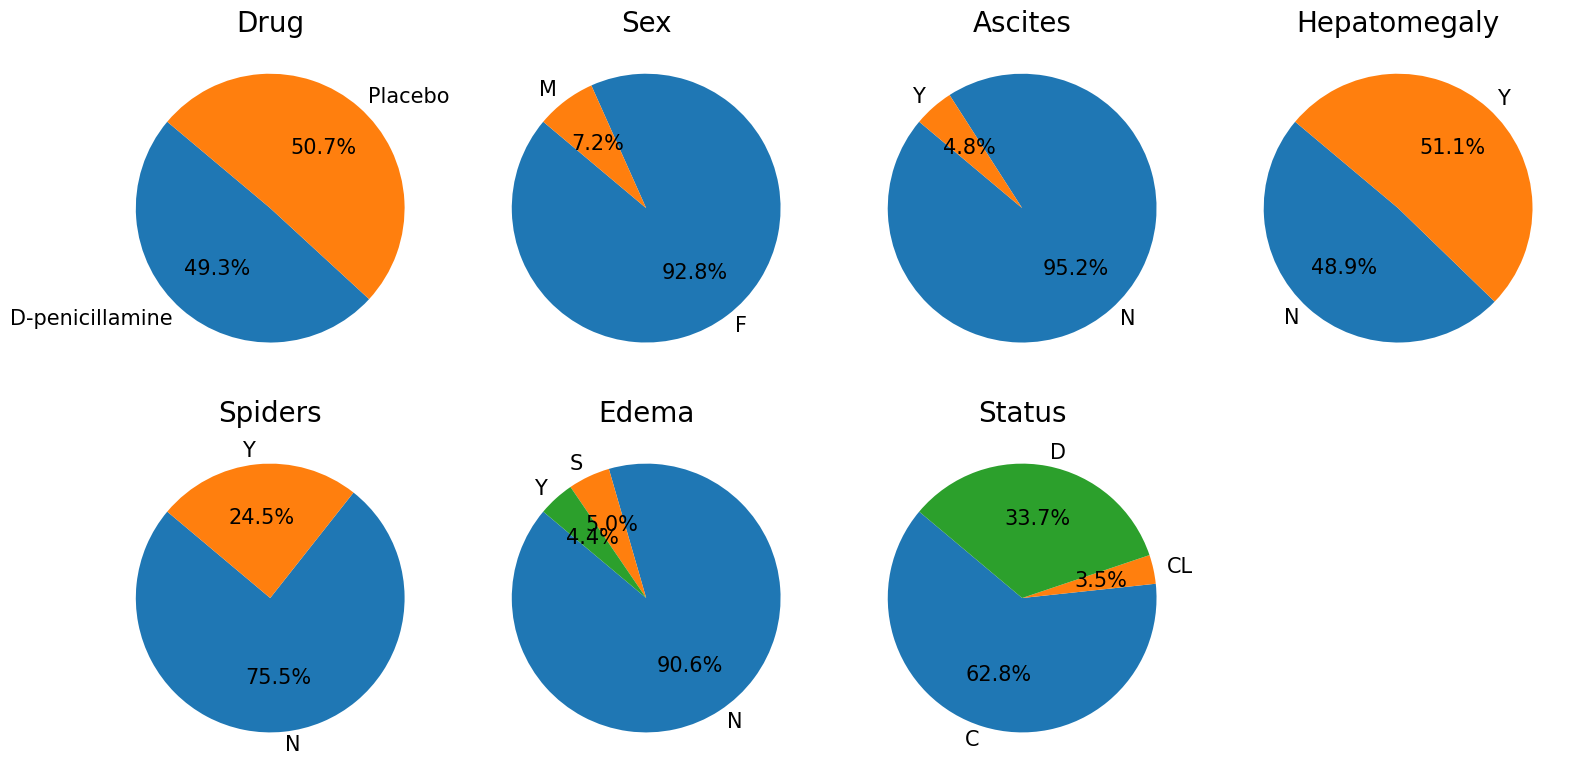

In [79]:
# Count the frequency of each category
category_counts = full_raw_train_data[['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema', 'Status']].apply(pd.Series.value_counts)

# Draw a pie chart
# Draw a pie chart
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()
plt.delaxes(ax=axes[7])
for i, col in enumerate(category_counts.columns):
    data = category_counts[col][category_counts[col] > 0] 
    data.plot.pie(ax=axes[i], autopct='%1.1f%%', startangle=140, textprops={'fontsize': 15})
    axes[i].set_title(col, fontsize=20)
    axes[i].set_ylabel('')
plt.tight_layout()
plt.show()

<h4>2.3.2 Categorical Features VS Status</h4>

In [80]:
from scipy.stats import chi2_contingency


cat_train = full_raw_train_data.select_dtypes(include = ['category'])
# Define an empty DataFrame to store the chi-square test results
chi2_results = pd.DataFrame(index=cat_train.columns[:-1], columns=['Chi2', 'P-value'])

# Traverse each classification feature
for col in cat_train.columns[:-1]:
    # Build contingency table
    contingency_table = pd.crosstab(cat_train[col], cat_train['Status'])
    # Perform a chi-square test
    chi2, p_value, _, _ = chi2_contingency(contingency_table)
    # Store results
    chi2_results.loc[col] = [chi2, p_value]

# Print chi-square test results
display(chi2_results)

## Through the chi-square test, we can see that the relationship between drug and status is not significant.

Chi2   P-value
Drug             5.881449  0.052827
Sex            135.111809       0.0
Ascites         605.19644       0.0
Hepatomegaly  1243.548926       0.0
Spiders        831.715175       0.0
Edema          922.519313       0.0

In [81]:
for feature in cat_train.columns[:-1]:
    display(pd.crosstab(cat_train[feature], cat_train['Status'], normalize='columns'))


Status                  C        CL         D
Drug                                         
D-penicillamine  0.484391  0.549091  0.502439
Placebo          0.515609  0.450909  0.497561

Status         C        CL         D
Sex                                 
F       0.953676  0.912727  0.881801
M       0.046324  0.087273  0.118199

Status          C        CL         D
Ascites                              
N        0.994965  0.978182  0.869043
Y        0.005035  0.021818  0.130957

Status               C        CL         D
Hepatomegaly                              
N             0.639275  0.396364  0.217636
Y             0.360725  0.603636  0.782364

Status          C        CL         D
Spiders                              
N        0.860423  0.701818  0.563227
Y        0.139577  0.298182  0.436773

Status         C        CL         D
Edema                               
N       0.976234  0.934545  0.771857
S       0.022155  0.058182  0.102439
Y       0.001611  0.007273  0.125704

<ul>
    <li>Hepatomegaly has a strong correlation with predicting the 3 classes</li>
    <li>Drug doesn't have a good correlation with predicting the 3 classes as mentioned above in the chi-squared test</li>
    <li>The other features are unbalanced as mentioned before and so they show a large disparity</li> 
</ul>

<h3>2.4 Numerical VS Categorical Features</h3>

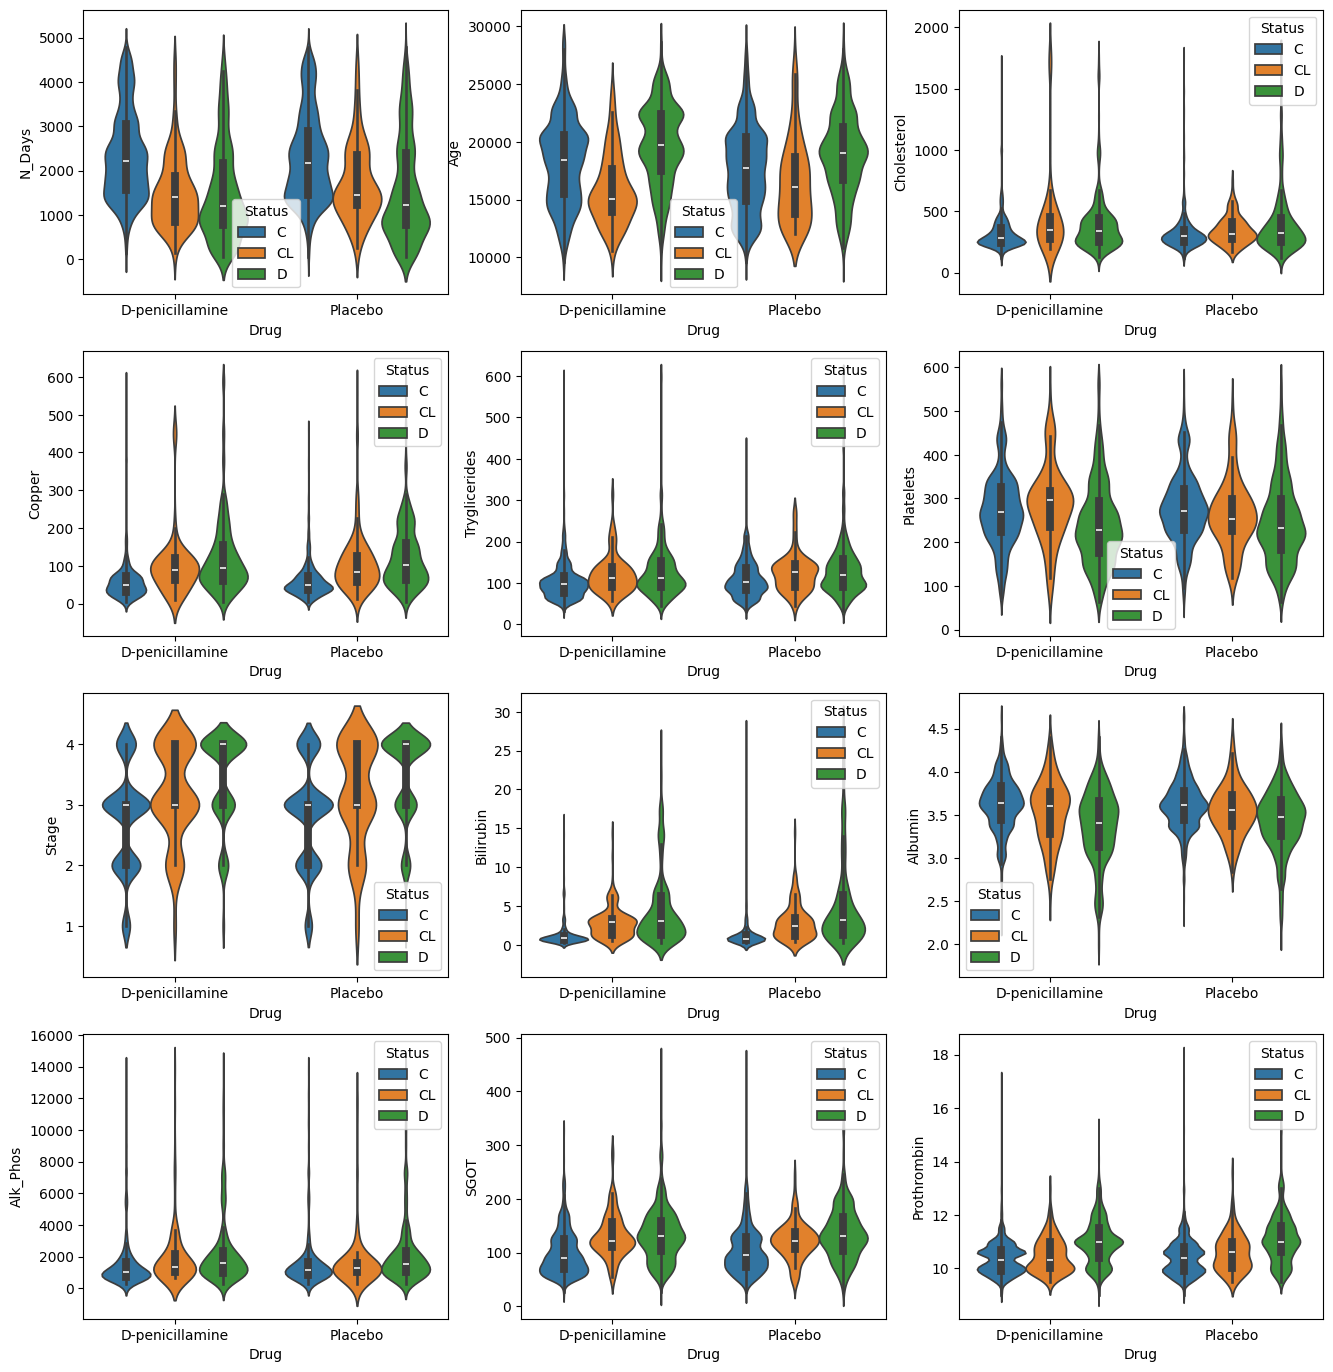

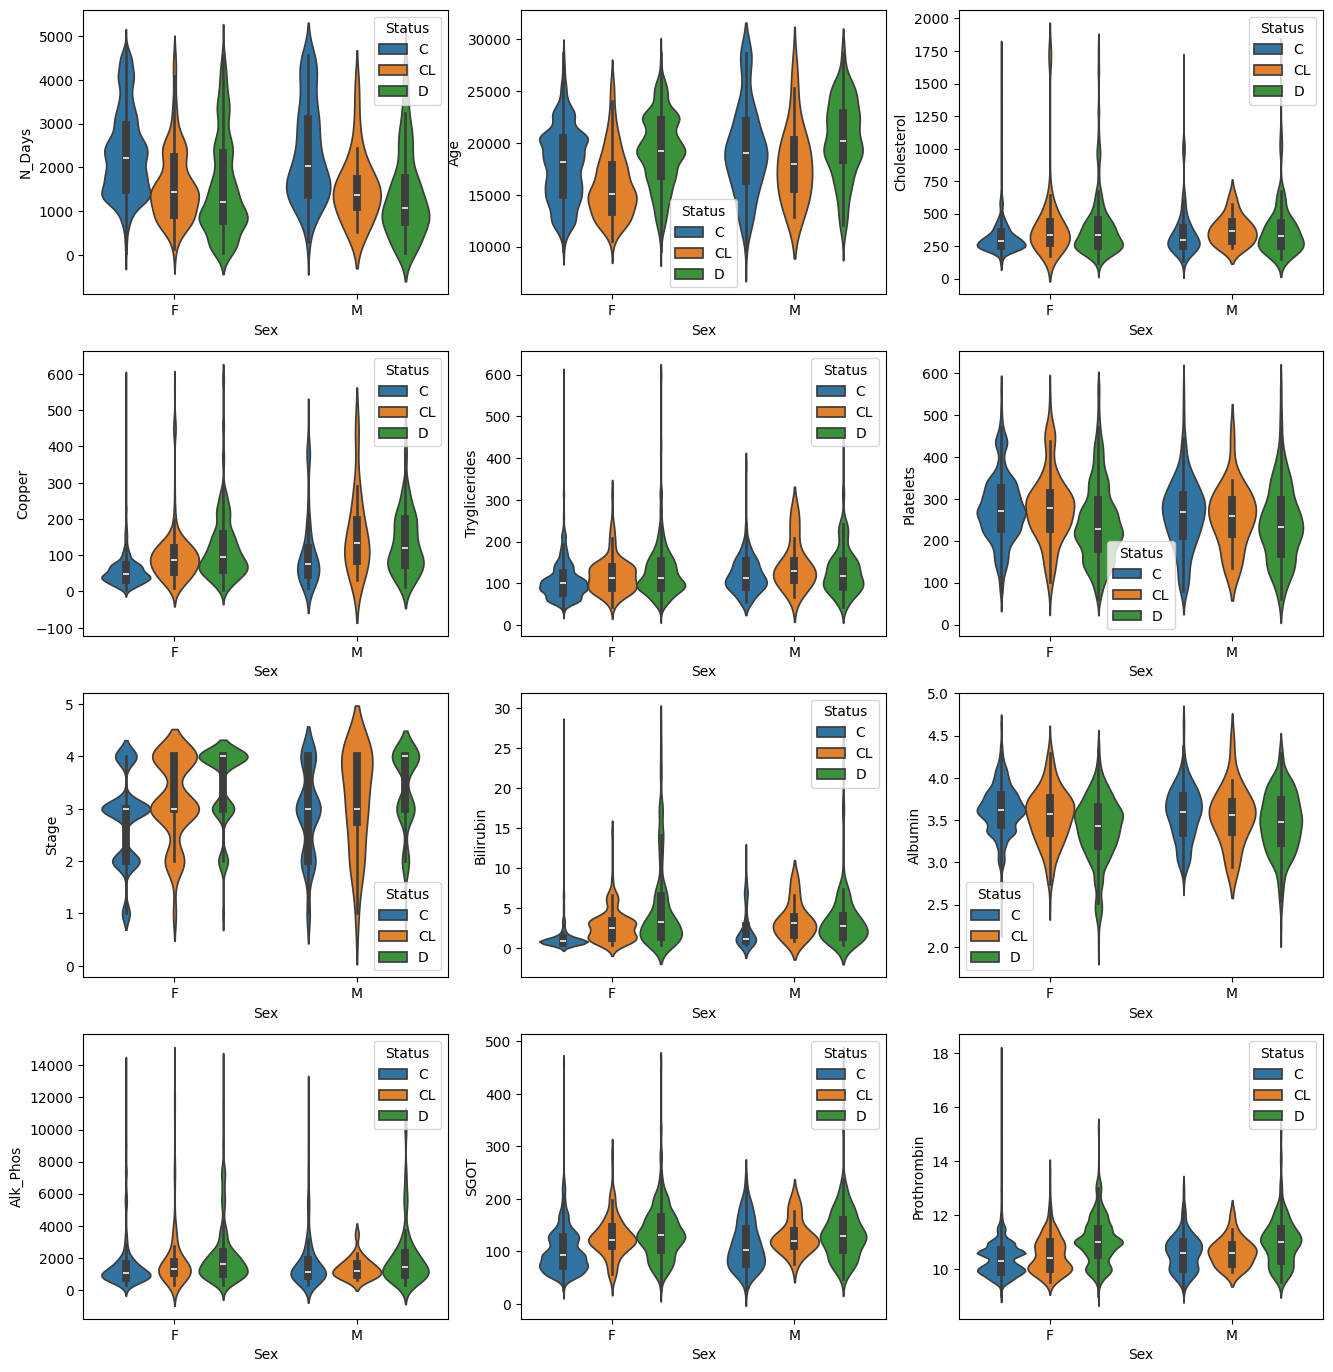

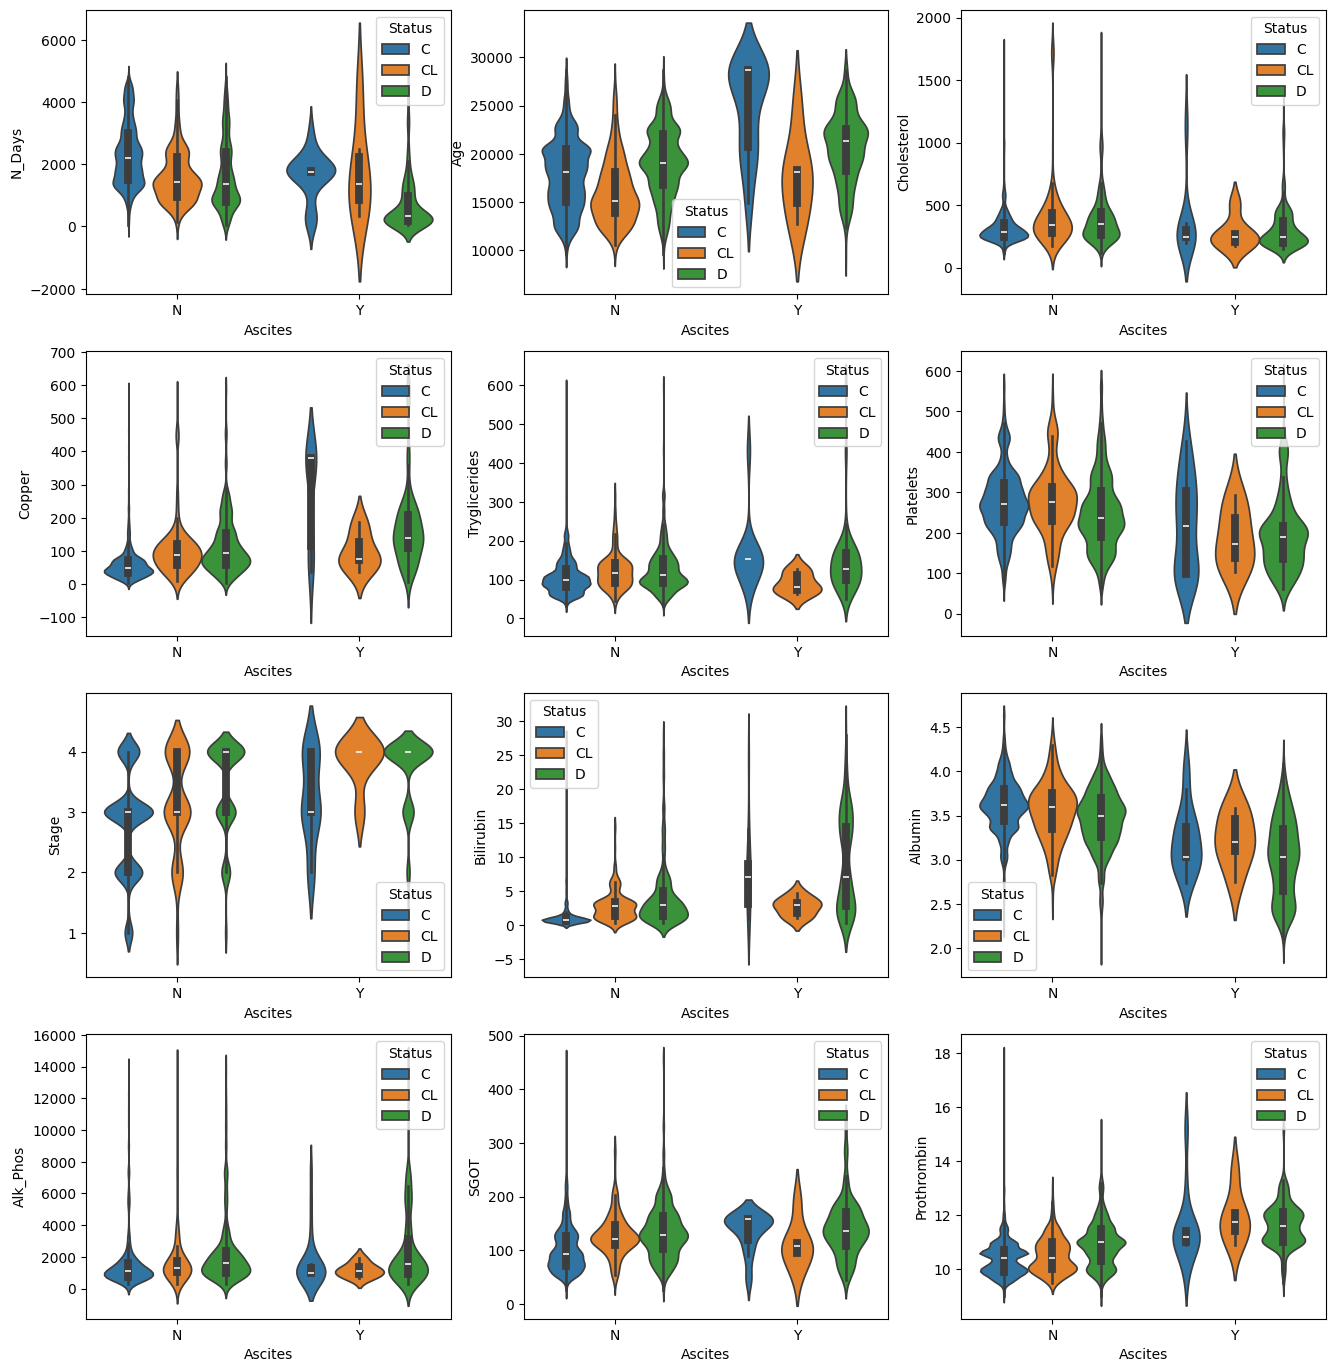

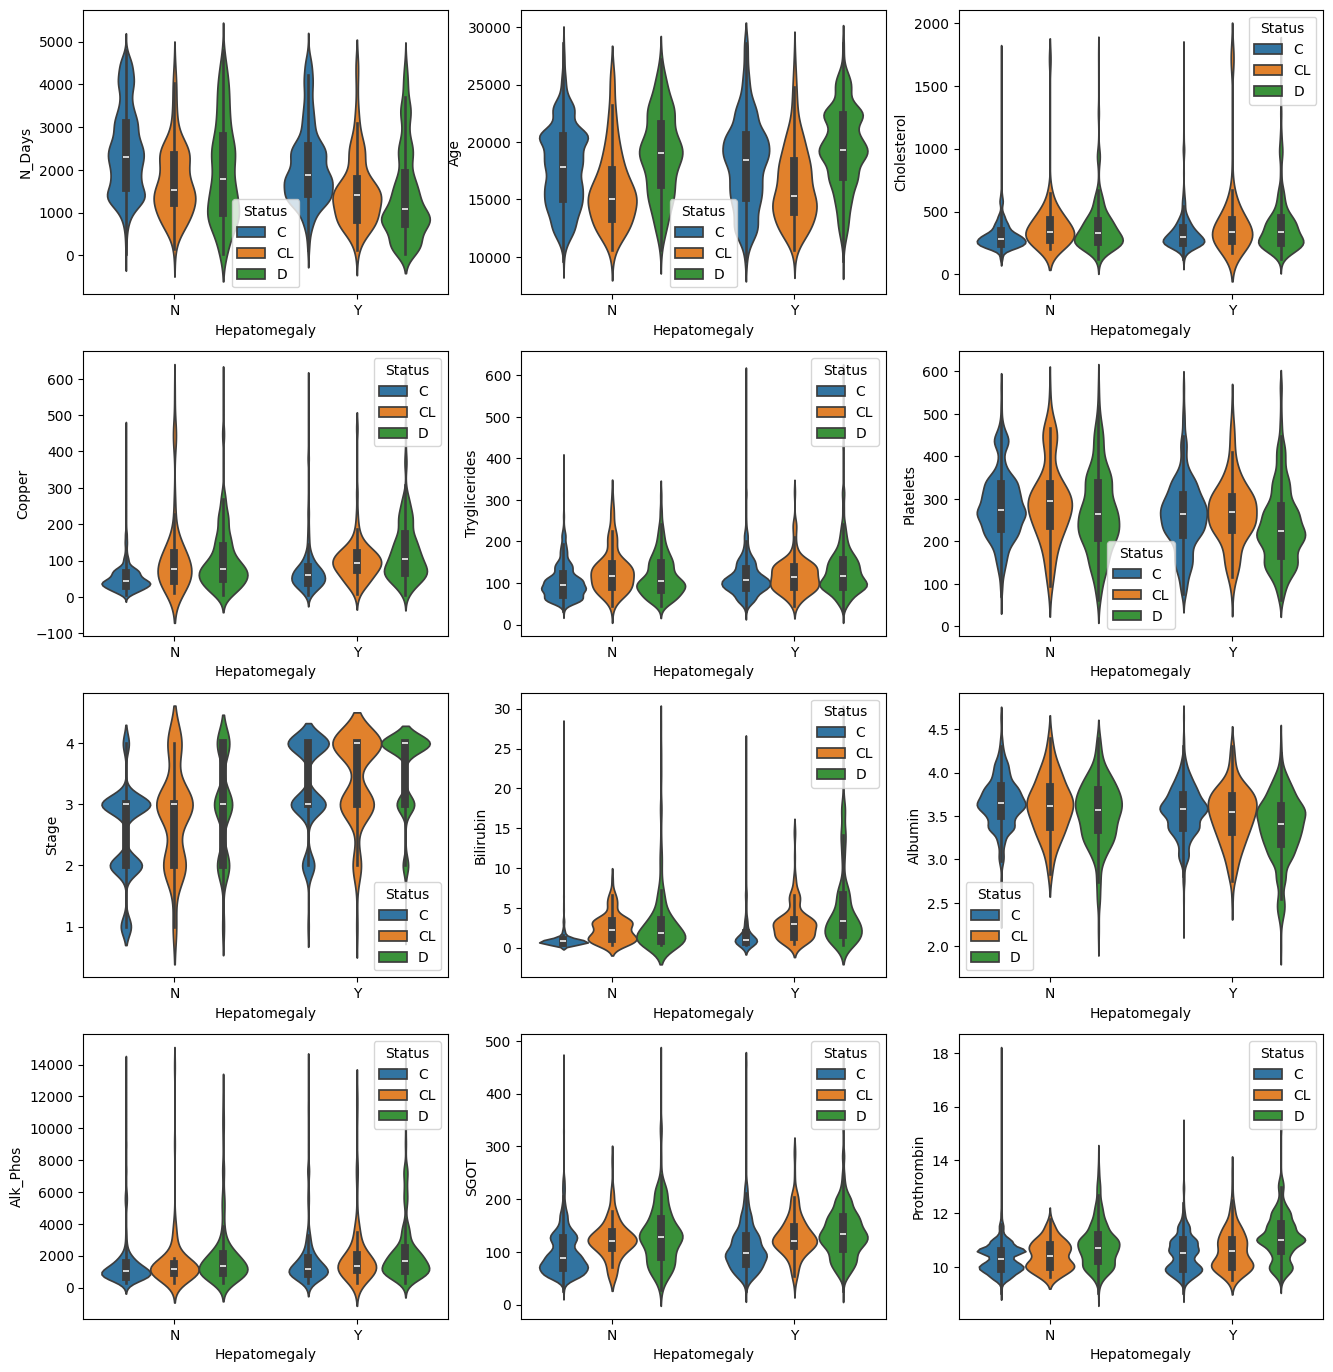

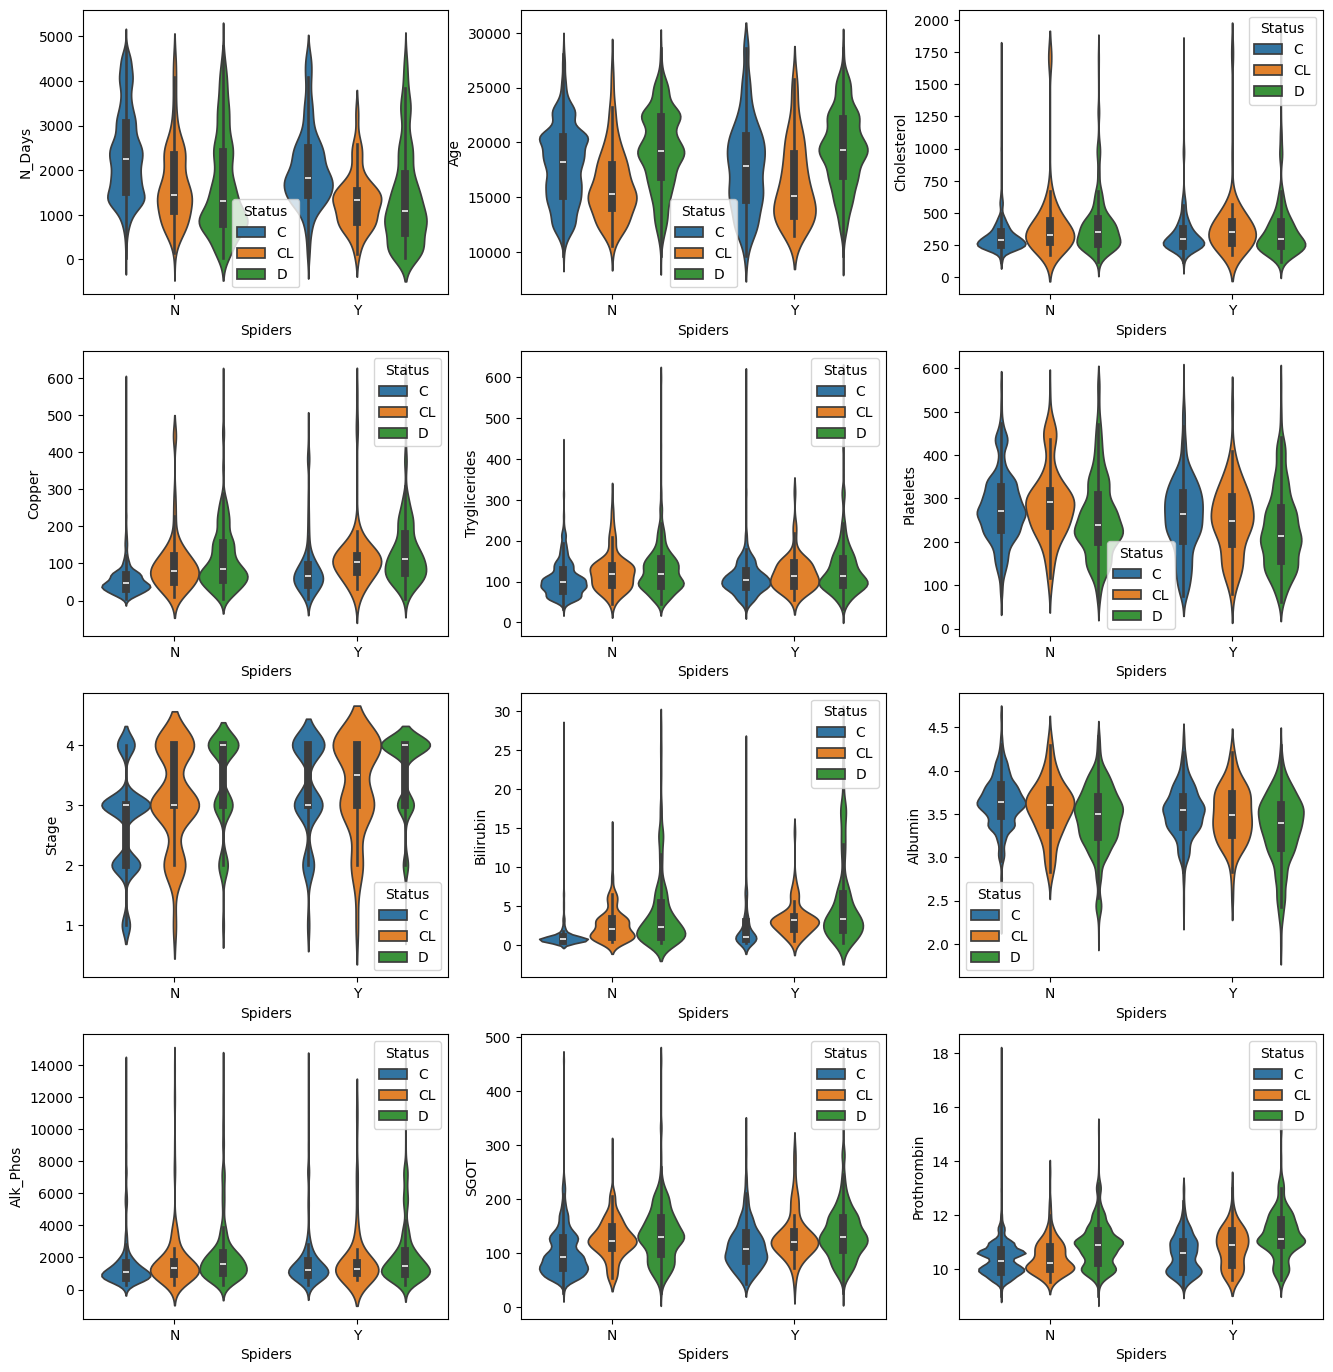

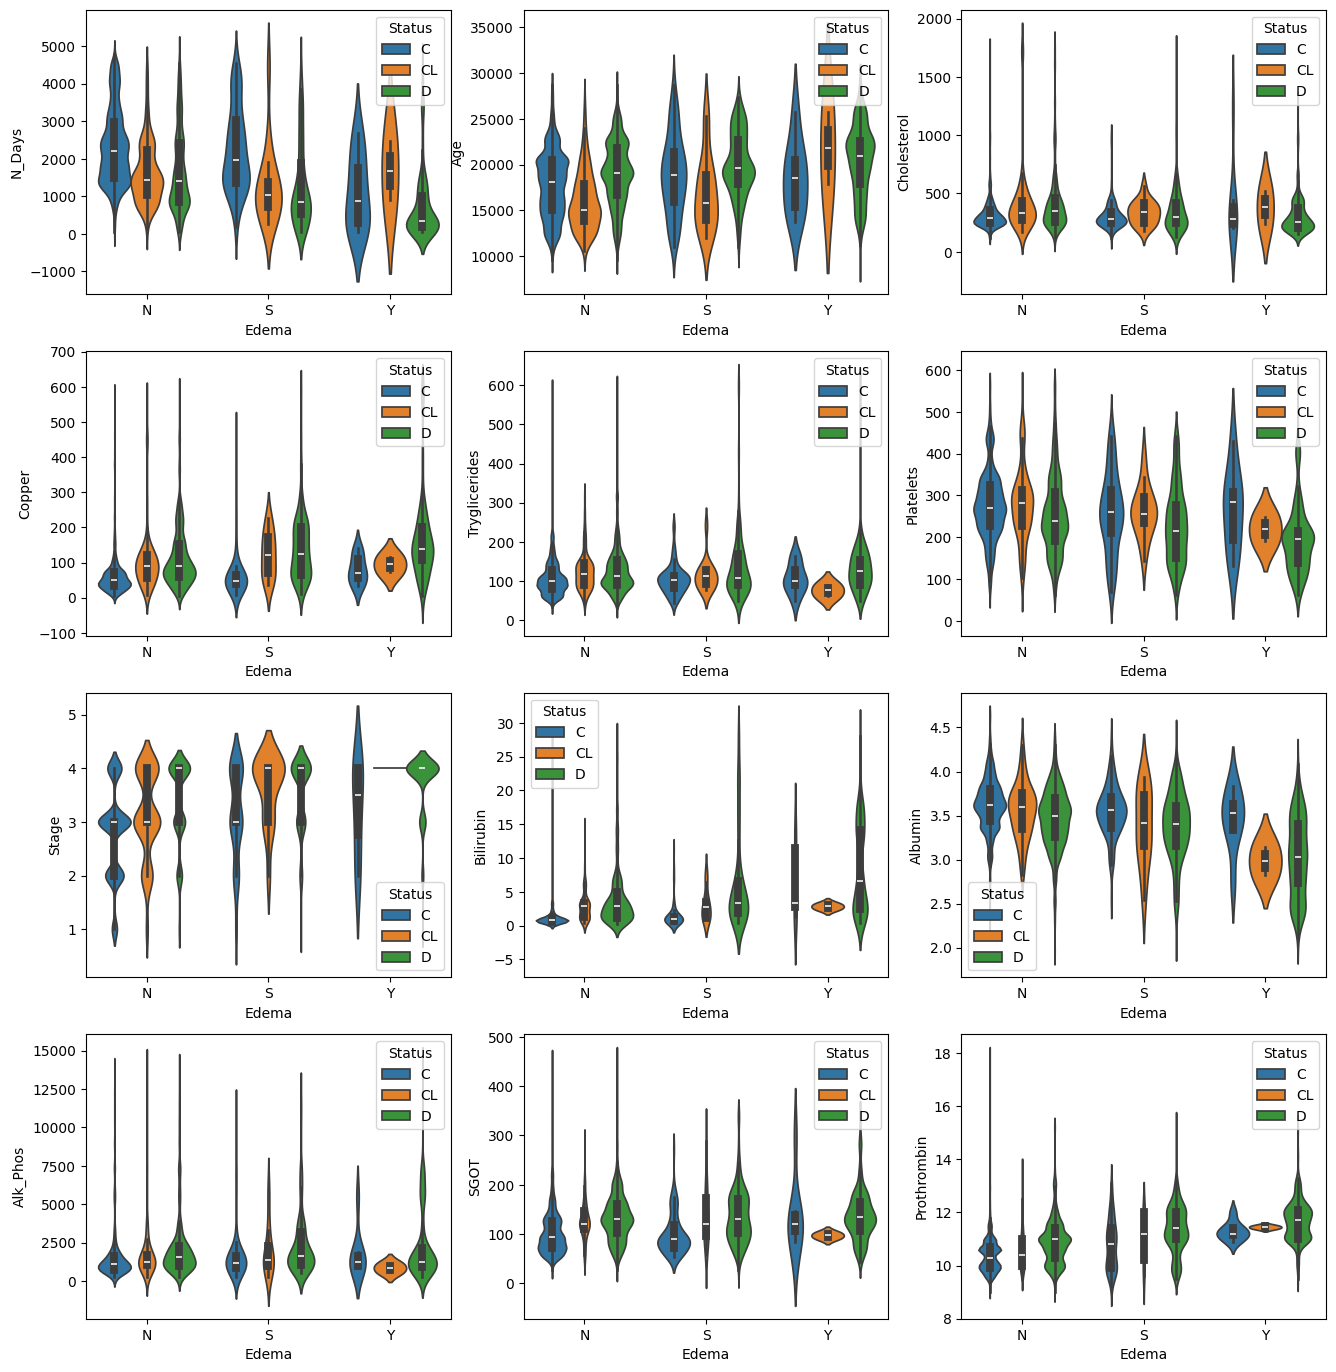

In [82]:
figures_y=4 
figures_x=3
categorical_feature_index=np.concatenate(np.where(full_raw_train_data.dtypes=='category'), axis=0)
for k in (categorical_feature_index)[:-1]:
    fig, axs=plt.subplots(figures_y,figures_x, figsize=(16,17))
    num_feature=0
    for j in range(figures_y):
        for i in range(figures_x):
            sns.violinplot(y=full_raw_train_data.columns[numerical_feature_index[num_feature]], x=full_raw_train_data.columns[k], data=full_raw_train_data, ax=axs[j,i], hue='Status')
            num_feature+=1

<h2>3. Data Imputation methods</h2>

Methods of imputation we will be considering in this project are: SimpleImputer, IterativeImputer, KNNImputer

<h3>3.1 SimpleImputer</h3>

Selection of attributes: keep all numerical attributes plus Spiders and Hepatomegaly

For numerical attributes: mean imputation or median imputation

For categorical attributes: mode imputation

imputer_1: mean imputation & mode imputation

imputer_2: median imputation & mode imputation

In [83]:
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, r2_score

In [84]:
# Function to randomly remove values from a specified column
def remove_values_from_column(df, column, num_to_remove):
    df_copy = df.copy()

    df_copy.loc[df_copy.sample(n=num_to_remove, random_state=42).index, column] = np.nan
    return df_copy

In [85]:
# Function to compare each imputed column with it's original data
# returns imputed column and metrics of perfomance
def imputation_performance_assessment(df, column, num_to_remove,imputor_number):
    df_copy = df.copy()
    
    # Save original values
    original_values = df[column].copy()
    
    # Remove values from the target column
    df_with_missing = remove_values_from_column(df_copy, column, num_to_remove)
    
    # Track indices of removed values 
    missing_indices = df_with_missing[df_with_missing[column].isna()].index
    
    # Impute missing values in the target column using mean or mode
    if df_with_missing[column].dtype == 'category':
        imputed_value = df_with_missing[column].mode()[0]
        df_with_missing[column].fillna(imputed_value, inplace=True)
    else:
        if(imputor_number==1):
            imputed_value = df_with_missing[column].mean()
            df_with_missing[column].fillna(imputed_value, inplace=True)
        if(imputor_number==2):
            imputed_value = df_with_missing[column].median()
            df_with_missing[column].fillna(imputed_value, inplace=True)

    
    #imputed_values = df_with_missing.loc[missing_indices, column]

    # Compare imputed values to original
    if df_with_missing[column].dtype == 'category' :
        # For categorical data, calculate accuracy of imputation
        correct_imputations = (original_values[missing_indices] == imputed_value).sum()
        accuracy = correct_imputations / len(missing_indices)
        metrics = {'imputation_accuracy': accuracy}
        return df_with_missing, metrics
    else:
        # For numerical data, calculate MSE between original and imputed values
        mse = mean_squared_error(original_values[missing_indices], [imputed_value] * len(missing_indices))
        metrics = {'imputation_mse': mse}
        return df_with_missing, metrics

In [86]:
#Returns fully imputed dataframe 
def impute_all_columns(df, num_to_remove, imputor_number):
    imputed_dfs = []
    df_copy = df.copy()
    
    fully_imputed_df = pd.DataFrame(index=df.index, columns=df.columns)
    
    # Loop through each column in the DataFrame
    for column in df_copy.columns:
        
        imputed_column_df, _ = imputation_performance_assessment(df_copy, column, num_to_remove, imputor_number)
        fully_imputed_df[column] = imputed_column_df[column]

    #rounds features that are supposed to be integers to 0 decimal places
    integer_column=['N_Days','Age','Cholesterol','Copper','Tryglicerides','Platelets','Stage']
    fully_imputed_df[integer_column]=(fully_imputed_df[integer_column].round(decimals=0))

    ###makes sure not to change the lables###
    fully_imputed_df['Status']=df['Status']
    
    return fully_imputed_df

In [87]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

# Takes orignal data, imputes and trains decision tree classifer 
def impute_and_predict(df, num_to_remove, imputor_number):
    
    df_imputed=impute_all_columns(df, num_to_remove, imputor_number)
    # Encoding categorical features

    
    
    categorical_cols = df_imputed.select_dtypes(include=['object', 'category']).columns
    categorical_cols = categorical_cols[categorical_cols != column]  # Exclude target if it's categorical
    for col in categorical_cols:
        le = LabelEncoder()
        df_imputed[col] = le.fit_transform(df_imputed[col].astype(str))
    
    # Determine if the target column is categorical for model selection
    is_classifier = df_imputed[column].dtype == 'object' or df_imputed[column].dtype.name == 'category'
    
    # Prepare features and target
    X = df_imputed.drop("Status", axis=1)
    y = df_imputed["Status"]
    

    
    if is_classifier:
        # Encode the target if it's categorical
        le = LabelEncoder()
        y = le.fit_transform(y.astype(str))
    
    # Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Initialize and train the model
    if is_classifier:
        model = DecisionTreeClassifier(random_state=5059, criterion='log_loss', min_samples_split=100)
#    else:
#        model = DecisionTreeRegressor(random_state=42)
    
    model.fit(X_train, y_train)
    
    # Predict and evaluate
    predictions = model.predict(X_test)
    if is_classifier:
        report=classification_report(y_test,predictions)
        confusionmatrix=confusion_matrix(y_test, predictions)
#    else:
#        score = mean_squared_error(y_test, predictions)
        


    return report, confusionmatrix 
   


<h4>3.1.1 Simple Imputer 1</h4>

In [88]:
copy1_raw_train_data=full_raw_train_data.copy()

In [89]:
df_train = copy1_raw_train_data.drop(['Drug', 'Sex', 'Ascites', 'Edema'], axis=1) #Unbalanced classes

In [90]:
results = []

values_to_remove = [395, 790, 1186]  
# Loop over each target column and each amount of missing data to assess
for column in df_train.columns:
    for num in values_to_remove:
        non_nan_count = df_train[column].dropna().shape[0]
        num_to_remove = min(num, non_nan_count)

        _,metrics = imputation_performance_assessment(df_train, column, num_to_remove,1)

        metrics['column'] = column
        metrics['num_removed'] = num_to_remove

        # Append the metrics to the results list
        results.append(metrics)

# Convert the results to a DataFrame
results_df = pd.DataFrame(results)

display(results_df)

imputation_mse         column  num_removed  imputation_accuracy
0     1.330451e+06         N_Days          395                  NaN
1     1.279686e+06         N_Days          790                  NaN
2     1.295789e+06         N_Days         1186                  NaN
3     1.348758e+07            Age          395                  NaN
4     1.432428e+07            Age          790                  NaN
5     1.395527e+07            Age         1186                  NaN
6              NaN   Hepatomegaly          395             0.508861
7              NaN   Hepatomegaly          790             0.501266
8              NaN   Hepatomegaly         1186             0.499157
9              NaN        Spiders          395             0.736709
10             NaN        Spiders          790             0.746835
11             NaN        Spiders         1186             0.748735
12    1.969750e+01      Bilirubin          395                  NaN
13    1.838858e+01      Bilirubin          790                  NaN
14    1.800561e+01      Bilirubin         1186                  NaN
15    4.840186e+04    Cholesterol          395                  NaN
16    4.597829e+04    Cholesterol          790                  NaN
17    4.038354e+04    Cholesterol         1186                  NaN
18    1.113452e-01        Albumin          395                  NaN
19    1.096832e-01        Albumin          790                  NaN
20    1.188110e-01        Albumin         1186                  NaN
21    7.263519e+03         Copper          395                  NaN
22    7.564196e+03         Copper          790                  NaN
23    7.060706e+03         Copper         1186                  NaN
24    3.761771e+06       Alk_Phos          395                  NaN
25    3.652753e+06       Alk_Phos          790                  NaN
26    3.854008e+06       Alk_Phos         1186                  NaN
27    2.219605e+03           SGOT          395                  NaN
28    2.470491e+03           SGOT          790                  NaN
29    2.530590e+03           SGOT         1186                  NaN
30    2.958998e+03  Tryglicerides          395                  NaN
31    3.640891e+03  Tryglicerides          790                  NaN
32    3.247711e+03  Tryglicerides         1186                  NaN
33    7.539231e+03      Platelets          395                  NaN
34    7.408913e+03      Platelets          790                  NaN
35    7.600594e+03      Platelets         1186                  NaN
36    6.547926e-01    Prothrombin          395                  NaN
37    6.290878e-01    Prothrombin          790                  NaN
38    6.056460e-01    Prothrombin         1186                  NaN
39    8.132884e-01          Stage          395                  NaN
40    7.695603e-01          Stage          790                  NaN
41    7.609835e-01          Stage         1186                  NaN
42             NaN         Status          395             0.589873
43             NaN         Status          790             0.606329
44             NaN         Status         1186             0.603710

In [91]:
results = []

values_to_remove = [395, 790, 1186]  
confusion_matrix_simple1=[]
# Loop over each target column and each amount of missing data to assess

for num in values_to_remove:
    Simple_report1, confusionmatrix1=impute_and_predict(df_train,num,1)

    confusion_matrix_simple1.append(confusionmatrix1)
    print('Classification report for ',num,'Values removed and mean imputer for numeric and mode for categorical data')
    print(Simple_report1)
    print(confusionmatrix1)

Classification report for  395 Values removed and mean imputer for numeric and mode for categorical data
              precision    recall  f1-score   support

           0       0.74      0.93      0.82       966
           1       1.00      0.02      0.04        52
           2       0.77      0.51      0.61       563

    accuracy                           0.75      1581
   macro avg       0.84      0.48      0.49      1581
weighted avg       0.76      0.75      0.72      1581

[[895   0  71]
 [ 37   1  14]
 [277   0 286]]
Classification report for  790 Values removed and mean imputer for numeric and mode for categorical data
              precision    recall  f1-score   support

           0       0.69      0.96      0.80       966
           1       1.00      0.02      0.04        52
           2       0.79      0.34      0.48       563

    accuracy                           0.71      1581
   macro avg       0.83      0.44      0.44      1581
weighted avg       0.74      0.71    

<h4>3.1.2 Simple Imputer 2</h4>

In [92]:
df_train = copy1_raw_train_data.drop(['Drug', 'Sex', 'Ascites', 'Edema'], axis=1)

In [93]:
results = []

values_to_remove = [395, 790, 1186]  

# Loop over each target column and each amount of missing data to assess
for column in df_train.columns:
    for num in values_to_remove:
        non_nan_count = df_train[column].dropna().shape[0]
        num_to_remove = min(num, non_nan_count)

        _,metrics = imputation_performance_assessment(df_train, column, num_to_remove,2)

        metrics['column'] = column
        metrics['num_removed'] = num_to_remove

        # Append the metrics to the results list
        results.append(metrics)

# Convert the results to a DataFrame
results_df = pd.DataFrame(results)

display(results_df)

imputation_mse         column  num_removed  imputation_accuracy
0     1.378013e+06         N_Days          395                  NaN
1     1.327037e+06         N_Days          790                  NaN
2     1.343390e+06         N_Days         1186                  NaN
3     1.338149e+07            Age          395                  NaN
4     1.425818e+07            Age          790                  NaN
5     1.389321e+07            Age         1186                  NaN
6              NaN   Hepatomegaly          395             0.508861
7              NaN   Hepatomegaly          790             0.501266
8              NaN   Hepatomegaly         1186             0.499157
9              NaN        Spiders          395             0.736709
10             NaN        Spiders          790             0.746835
11             NaN        Spiders         1186             0.748735
12    2.303043e+01      Bilirubin          395                  NaN
13    2.135268e+01      Bilirubin          790                  NaN
14    2.088336e+01      Bilirubin         1186                  NaN
15    5.186703e+04    Cholesterol          395                  NaN
16    4.908857e+04    Cholesterol          790                  NaN
17    4.305274e+04    Cholesterol         1186                  NaN
18    1.124570e-01        Albumin          395                  NaN
19    1.102968e-01        Albumin          790                  NaN
20    1.197137e-01        Albumin         1186                  NaN
21    7.889992e+03         Copper          395                  NaN
22    8.218089e+03         Copper          790                  NaN
23    7.654468e+03         Copper         1186                  NaN
24    4.153576e+06       Alk_Phos          395                  NaN
25    4.049531e+06       Alk_Phos          790                  NaN
26    4.265499e+06       Alk_Phos         1186                  NaN
27    2.245557e+03           SGOT          395                  NaN
28    2.514975e+03           SGOT          790                  NaN
29    2.577740e+03           SGOT         1186                  NaN
30    3.071387e+03  Tryglicerides          395                  NaN
31    3.812875e+03  Tryglicerides          790                  NaN
32    3.366788e+03  Tryglicerides         1186                  NaN
33    7.536073e+03      Platelets          395                  NaN
34    7.401806e+03      Platelets          790                  NaN
35    7.600164e+03      Platelets         1186                  NaN
36    6.585316e-01    Prothrombin          395                  NaN
37    6.314684e-01    Prothrombin          790                  NaN
38    6.071332e-01    Prothrombin         1186                  NaN
39    8.126582e-01          Stage          395                  NaN
40    7.708861e-01          Stage          790                  NaN
41    7.622260e-01          Stage         1186                  NaN
42             NaN         Status          395             0.589873
43             NaN         Status          790             0.606329
44             NaN         Status         1186             0.603710

In [94]:
results = []

values_to_remove = [395, 790, 1186]  
confusion_matrix_simple2=[]

# Loop over each target column and each amount of missing data to assess
for num in values_to_remove:
    Simple_report2, confusionmatrix2=impute_and_predict(df_train,num,2)

    confusion_matrix_simple2.append(confusionmatrix2)
    print('Classification report for ',num,'Values removed and median imputer for numeric and mode for categorical data')
    print(Simple_report2)
    print(confusionmatrix2)

Classification report for  395 Values removed and median imputer for numeric and mode for categorical data
              precision    recall  f1-score   support

           0       0.74      0.93      0.82       966
           1       1.00      0.02      0.04        52
           2       0.77      0.51      0.61       563

    accuracy                           0.75      1581
   macro avg       0.84      0.48      0.49      1581
weighted avg       0.76      0.75      0.72      1581

[[895   0  71]
 [ 37   1  14]
 [277   0 286]]
Classification report for  790 Values removed and median imputer for numeric and mode for categorical data
              precision    recall  f1-score   support

           0       0.69      0.96      0.80       966
           1       1.00      0.02      0.04        52
           2       0.79      0.34      0.48       563

    accuracy                           0.71      1581
   macro avg       0.83      0.44      0.44      1581
weighted avg       0.74      0.71

Simple Imputer 1 and 2 have the same performance and the best performance is when less data is removed.

In [95]:
Simple_report1, confusionmatrix1=impute_and_predict(df_train,values_to_remove[0],1)
Simple_report2, confusionmatrix2=impute_and_predict(df_train,values_to_remove[0],2)

<h3>3.2 IterativeImputer</h3>

In [96]:
copy2_raw_train_data=full_raw_train_data.copy()

In [111]:
# Create list for each continuous attribute
cts_var = ["N_Days", "Age", "Bilirubin", "Cholesterol", "Albumin", "Copper", "Alk_Phos", "SGOT",
           "Tryglicerides", "Platelets", "Prothrombin", "Stage"]
# Create list for each dicrete attribute
d_var = ["Drug", "Sex", "Ascites", "Hepatomegaly", "Spiders", "Edema"]

# Data imputation
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import LabelEncoder
# The training data does not contain any missing values
# Remove a small randomly selected portion of the training data to test data imputation methods
# Label encoding for the discrete variables
le = LabelEncoder()
for i in d_var:
    copy2_raw_train_data[i] = le.fit_transform(copy2_raw_train_data[i])
copy2_raw_train_data["Status"] = le.fit_transform(copy2_raw_train_data['Status'])

# Create a new training set with missing values
train_r = copy2_raw_train_data

# Remove id and status columns
train_r = train_r.drop("Status", axis=1)

# Function to remove data values and replace them with NA
def remove_values(data, remove = 0.05):
    x = len(data)
    p = int(np.round(x * remove))
    for i in data.columns:
        s = np.random.default_rng().integers(0, high = x, size = p)
        data[i].iloc[[s]] = np.nan
    
    return data

# Implement the iterative imputer
imp = IterativeImputer(random_state=14)
imp_fit = imp.fit_transform(remove_values(train_r, remove=0.05))
train_imp = pd.DataFrame(imp_fit, columns=train_r.columns)


#Round the values that are supposed to be integers(categorical data and values in list below) to 0 decimal places
integer_column=['N_Days','Age','Cholesterol','Copper','Tryglicerides','Platelets','Stage']
train_imp[integer_column+d_var]=(train_imp[integer_column+d_var].round(decimals=0))


In [112]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import classification_report

numerical_feature=['N_Days','Age','Bilirubin','Cholesterol','Albumin','Copper','Alk_Phos','SGOT','Tryglicerides','Platelets','Prothrombin']
categorical_feature=['Drug','Sex','Ascites','Hepatomegaly','Spiders','Edema']
ordinal_feature=['Stage']

full_pipeline = ColumnTransformer([("numerical", StandardScaler(), numerical_feature),
                                   ("categorical", OneHotEncoder(sparse_output=False), categorical_feature),
                                   ('ordinal', OrdinalEncoder(),ordinal_feature)])

full_pipeline.set_output(transform="pandas")

X_prepared_train = full_pipeline.fit_transform(train_imp)
y_prepared_train=copy2_raw_train_data['Status']

X_prepared_train, X_prepared_valid, y_prepared_train, y_prepared_valid= train_test_split(X_prepared_train,y_prepared_train , 
                                                                                         test_size=0.2, random_state=5059)

tree_classifier = DecisionTreeClassifier(random_state=5059, criterion='log_loss', min_samples_split=100)
tree_classifier.fit(X_prepared_train, y_prepared_train)

validation_prediction = tree_classifier.predict(X_prepared_valid)

iterative_report=classification_report(y_prepared_valid, validation_prediction)
confusion_matrix_iterative=confusion_matrix(y_prepared_valid, validation_prediction)
print("Classification report for Iterative Imputer with 0.05 fraction of data removed ")
print(iterative_report)


Classification report for Iterative Imputer with 0.05 fraction of data removed 
              precision    recall  f1-score   support

           0       0.82      0.90      0.86      1008
           1       0.20      0.02      0.03        61
           2       0.73      0.66      0.69       512

    accuracy                           0.79      1581
   macro avg       0.58      0.53      0.53      1581
weighted avg       0.77      0.79      0.77      1581



<h3>3.3 KNNImputer</h3>

In [99]:
copy3_raw_train_data, copy3_raw_valid_data =train_test_split(full_raw_train_data, test_size=0.2, random_state=5059)

In [100]:
integer_column=['N_Days','Age','Cholesterol','Copper','Tryglicerides','Platelets','Stage']
categorical_column=['Drug','Sex','Ascites','Hepatomegaly','Spiders','Edema', 'Status']
float_column=['Bilirubin','Albumin','Alk_Phos','SGOT','Prothrombin']

for i in categorical_column:
    copy3_raw_train_data[i] = pd.Categorical(copy3_raw_train_data[i])

for i in integer_column:
    copy3_raw_train_data[i] = copy3_raw_train_data[i].astype('int64')

for i in float_column:
    copy3_raw_train_data[i] = copy3_raw_train_data[i].astype('float')

copy3_raw_train_data_label=copy3_raw_train_data['Status']
copy3_raw_train_data=copy3_raw_train_data.drop('Status', axis=1)

copy3_raw_valid_data_label=copy3_raw_valid_data['Status']
copy3_raw_valid_data=copy3_raw_valid_data.drop('Status', axis=1)


In [101]:
# Ordinal encode all categorical features except Status to be able to apply KNNImputer
from sklearn.preprocessing import OrdinalEncoder
ordinal_columns=['Drug','Sex','Ascites','Hepatomegaly','Spiders','Edema']

ordinal_encoder=OrdinalEncoder()

copy3_raw_train_data[ordinal_columns]=ordinal_encoder.fit_transform(copy3_raw_train_data[ordinal_columns])
copy3_raw_valid_data[ordinal_columns]=ordinal_encoder.transform(copy3_raw_valid_data[ordinal_columns])

#convert into datatype that can accept NaN values
copy3_raw_train_data=copy3_raw_train_data.convert_dtypes()
copy3_raw_valid_data=copy3_raw_valid_data.convert_dtypes()

In [102]:
#possible error, in event all data from column is NaN-ed the column is removed and error will occur, 
#recommendation: keep percentage_removed_end < 85
from sklearn.impute import KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier

categorical_ordinal_columns=['Drug','Sex','Ascites','Hepatomegaly','Spiders','Edema']



first_nn=3
final_nn=1000
steps_nn=100

percentage_removed_start=0
percentage_removed_end=30
steps_percentage_removed=5

scores_nn_train=[]
scores_nn_valid=[]
for NN in range(first_nn,final_nn, steps_nn):
    scores_nn_train.append([])
    scores_nn_valid.append([])

actual_fraction_list=[]


master_df=copy3_raw_train_data.copy()
for frac in range(percentage_removed_start,percentage_removed_end, steps_percentage_removed):
    print(frac)
    # creates NaNs
    copy3_raw_train_data=master_df.copy()
    for i in range(copy3_raw_train_data.shape[0]):
        for j in range(copy3_raw_train_data.shape[1]):
            if random.randint(0,99) < frac:
                copy3_raw_train_data.iloc[i,j]=np.nan

    #calculates fraction of NaNs
    actual_fraction_list.append(((copy3_raw_train_data.isnull().sum() / len(copy3_raw_train_data)).sum())/copy3_raw_train_data.shape[1])
    print(((copy3_raw_train_data.isnull().sum() / len(copy3_raw_train_data)).sum())/copy3_raw_train_data.shape[1])
    # imputes for range of nearest neighbours
    scores_nn_counter=0
    for NN in range(first_nn,final_nn, steps_nn):
        missing_values_data=copy3_raw_train_data.copy()
        KNNimputer_instance = KNNImputer(n_neighbors=NN, weights="uniform")
        KNNimputer_instance.set_output(transform='pandas')
        missing_values_data=KNNimputer_instance.fit_transform(missing_values_data)
        missing_values_data[integer_column+ordinal_columns]=(missing_values_data[integer_column+ordinal_columns].round(decimals=0))


        imputed_train_data=pd.concat([missing_values_data, copy3_raw_train_data_label], axis=1)

        #switch data types
        for i in categorical_column:
            imputed_train_data[i] = pd.Categorical(imputed_train_data[i])

        for i in integer_column:
            imputed_train_data[i] = imputed_train_data[i].astype('int64')

        for i in float_column:
            imputed_train_data[i] = imputed_train_data[i].astype('float')


        #scales and encodes data
        numerical_feature=['N_Days','Age','Bilirubin','Cholesterol','Albumin','Copper','Alk_Phos','SGOT','Tryglicerides','Platelets','Prothrombin']
        categorical_feature=['Drug','Sex','Ascites','Hepatomegaly','Spiders','Edema']
        ordinal_feature=['Stage']

        full_pipeline = ColumnTransformer([("numerical", StandardScaler(), numerical_feature),
                                        ("categorical", OneHotEncoder(sparse_output=False), categorical_feature),
                                        ('ordinal', OrdinalEncoder(),ordinal_feature)])

        full_pipeline.set_output(transform="pandas")

        X_prepared_train = full_pipeline.fit_transform(imputed_train_data)
        y_prepared_train=imputed_train_data['Status']

        X_prepared_valid=full_pipeline.transform(copy3_raw_valid_data)
        y_prepared_valid=copy3_raw_valid_data_label


        #fits simple decison tree
        tree_classifier = DecisionTreeClassifier(random_state=5059, criterion='log_loss', min_samples_split=100)
        tree_classifier.fit(X_prepared_train, y_prepared_train)

        #scores model on train
        scores_nn_train[scores_nn_counter].append(tree_classifier.score(X_prepared_train, y_prepared_train))
        scores_nn_valid[scores_nn_counter].append(tree_classifier.score(X_prepared_valid, y_prepared_valid))

    
        
        scores_nn_counter+=1

0
0.0
5


0.04952913064867523
10
0.1006834633494975
15
0.15095052357860705
20
0.19865240002811163
25
0.2500614941317029


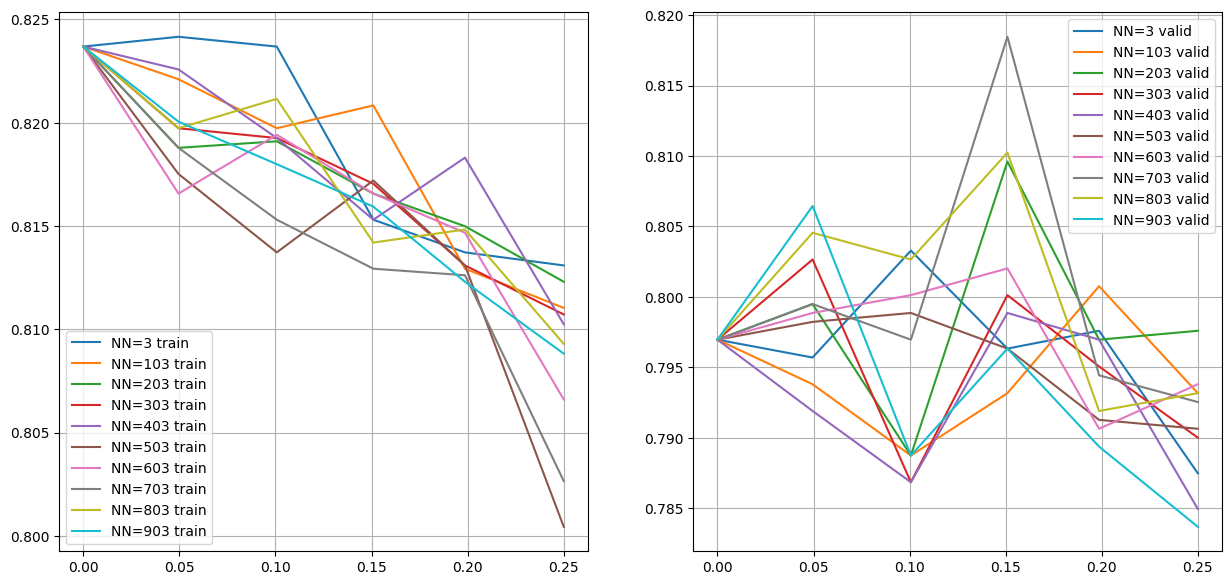

In [103]:
fig, axs= plt.subplots(1,2,figsize=(15,7))
labels=[]
for i in range(first_nn, final_nn, steps_nn):
    labels.append(str(i)) 

for i in range(len(scores_nn_train)):
    axs[0].plot(actual_fraction_list,scores_nn_train[i], label='NN='+labels[i]+' train')
    axs[1].plot(actual_fraction_list,scores_nn_valid[i], label='NN='+labels[i]+' valid')


axs[0].legend()
axs[1].legend()

axs[0].grid(0.05)
axs[1].grid()

KNN imputation gets worse as more data is removed.

For validation set:
<ul>
<li>slight improvement in validation set initially when less than ~15% is removed for some nearest neighbours.</li>
<ul>

Recommendation is to use NN=3 and less than 10% of data removed. This has both a high score and faster calculations as it doesn't have to look at that many neighbours.


<h4>3.3.1 Using Recommmendation</h4>

In [104]:
integer_column=['N_Days','Age','Cholesterol','Copper','Tryglicerides','Platelets','Stage']
categorical_column=['Drug','Sex','Ascites','Hepatomegaly','Spiders','Edema', 'Status']
float_column=['Bilirubin','Albumin','Alk_Phos','SGOT','Prothrombin']
###

copy3_raw_train_data, copy3_raw_valid_data =train_test_split(full_raw_train_data, test_size=0.2, random_state=5059)


copy3_raw_train_data[ordinal_columns]=ordinal_encoder.fit_transform(copy3_raw_train_data[ordinal_columns])
copy3_raw_valid_data[ordinal_columns]=ordinal_encoder.transform(copy3_raw_valid_data[ordinal_columns])


#convert into datatype that can accept NaN values
copy3_raw_train_data=copy3_raw_train_data.convert_dtypes()
copy3_raw_valid_data=copy3_raw_valid_data.convert_dtypes()

copy3_raw_train_data_label=copy3_raw_train_data['Status']
copy3_raw_train_data=copy3_raw_train_data.drop('Status', axis=1)

copy3_raw_valid_data_label=copy3_raw_valid_data['Status']
copy3_raw_valid_data=copy3_raw_valid_data.drop('Status', axis=1)



for i in range(copy3_raw_train_data.shape[0]):
    for j in range(copy3_raw_train_data.shape[1]):
        if random.randint(0,99) < 10:
            copy3_raw_train_data.iloc[i,j]=np.nan


KNNimputer_instance = KNNImputer(n_neighbors=3, weights="uniform")
KNNimputer_instance.set_output(transform='pandas')
copy3_raw_train_data=KNNimputer_instance.fit_transform(copy3_raw_train_data)
copy3_raw_train_data[integer_column+categorical_ordinal_columns]=(copy3_raw_train_data[integer_column+categorical_ordinal_columns].round(decimals=0))


imputed_train_data=pd.concat([copy3_raw_train_data, copy3_raw_train_data_label], axis=1)



#switch data types
for i in categorical_column:
    imputed_train_data[i] = pd.Categorical(imputed_train_data[i])

for i in integer_column:
    imputed_train_data[i] = imputed_train_data[i].astype('int64')

for i in float_column:
   imputed_train_data[i] = imputed_train_data[i].astype('float')



numerical_feature=['N_Days','Age','Bilirubin','Cholesterol','Albumin','Copper','Alk_Phos','SGOT','Tryglicerides','Platelets','Prothrombin']
categorical_feature=['Drug','Sex','Ascites','Hepatomegaly','Spiders','Edema']
ordinal_feature=['Stage']

full_pipeline = ColumnTransformer([("numerical", StandardScaler(), numerical_feature),
                                   ("categorical", OneHotEncoder(sparse_output=False), categorical_feature),
                                   ('ordinal', OrdinalEncoder(),ordinal_feature)])

full_pipeline.set_output(transform="pandas")

X_prepared_train = full_pipeline.fit_transform(imputed_train_data)
y_prepared_train=imputed_train_data['Status']
tree_classifier = DecisionTreeClassifier(random_state=5059, criterion='log_loss', min_samples_split=100)
tree_classifier.fit(X_prepared_train, y_prepared_train)

X_prepared_valid=full_pipeline.transform(copy3_raw_valid_data)
y_prepared_valid=copy3_raw_valid_data_label

validation_prediction = tree_classifier.predict(X_prepared_valid)

KNN_report=classification_report(y_prepared_valid, validation_prediction)
confusion_matrix_KNN=confusion_matrix(y_prepared_valid, validation_prediction)
print("Classification report for KNN Imputer with 0.1 fraction of data removed and 3 nearest neighbours")
print(KNN_report)


Classification report for KNN Imputer with 0.1 fraction of data removed and 3 nearest neighbours
              precision    recall  f1-score   support

           C       0.82      0.89      0.86      1008
          CL       0.00      0.00      0.00        61
           D       0.73      0.70      0.72       512

    accuracy                           0.79      1581
   macro avg       0.52      0.53      0.52      1581
weighted avg       0.76      0.79      0.78      1581



Slight variation in scores depending on what 10% of data is removed and then imputed but in general performs similarly to baseline in Section 4.1. Almost always performs worse on CL data by predicting no CL outcomes. 

<h3>3.4 Comparing Imputers</h3>

In [113]:
print ("Simple Imputer 1: mean for numeric, mode for categorical, 5% removed")
print (Simple_report1)

print ("Simple Imputer 2: median for numeric, mode for categorical, 5% removed")
print(Simple_report2)

print ("Iterative Imputer: 5% removed")
print(iterative_report)

print('KNN Imputer: 10% removed 3 nearest neighbours')
print(KNN_report)

Simple Imputer 1: mean for numeric, mode for categorical, 5% removed
              precision    recall  f1-score   support

           0       0.74      0.93      0.82       966
           1       1.00      0.02      0.04        52
           2       0.77      0.51      0.61       563

    accuracy                           0.75      1581
   macro avg       0.84      0.48      0.49      1581
weighted avg       0.76      0.75      0.72      1581

Simple Imputer 2: median for numeric, mode for categorical, 5% removed
              precision    recall  f1-score   support

           0       0.74      0.93      0.82       966
           1       1.00      0.02      0.04        52
           2       0.77      0.51      0.61       563

    accuracy                           0.75      1581
   macro avg       0.84      0.48      0.49      1581
weighted avg       0.76      0.75      0.72      1581

Iterative Imputer: 5% removed
              precision    recall  f1-score   support

           0 

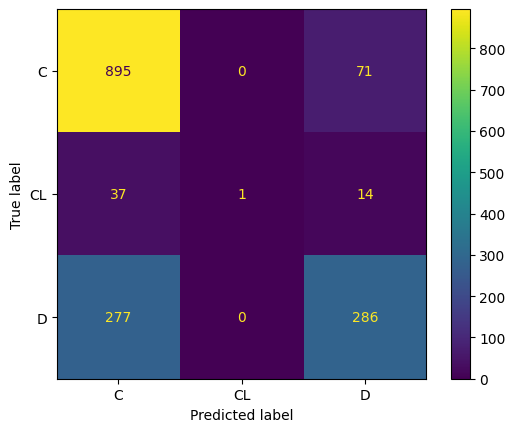

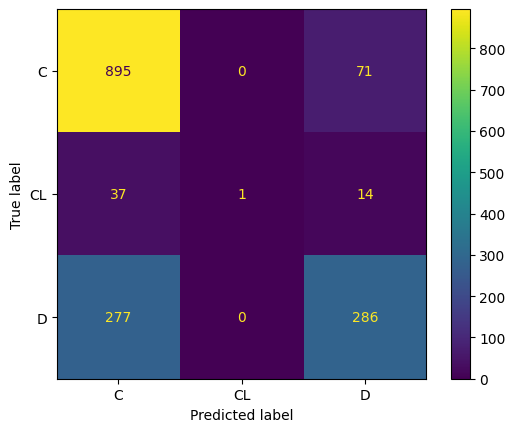

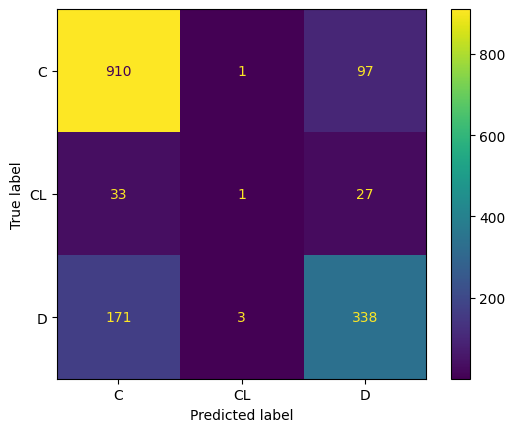

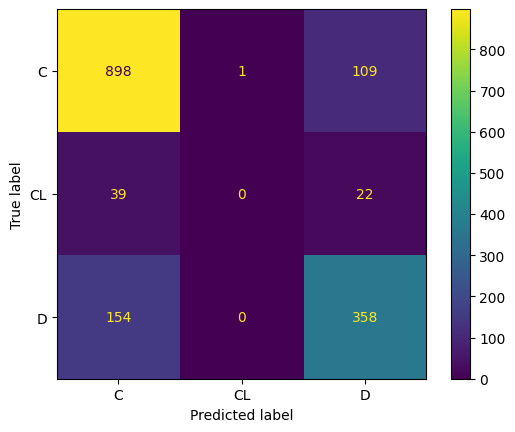

In [114]:
from sklearn.metrics import ConfusionMatrixDisplay

simple1_disp=ConfusionMatrixDisplay(confusion_matrix_simple1[0], display_labels=['C','CL','D'])
simple2_disp=ConfusionMatrixDisplay(confusion_matrix_simple2[0], display_labels=['C','CL','D'])
iterative_disp=ConfusionMatrixDisplay(confusion_matrix_iterative, display_labels=['C','CL','D'])
KNN_disp=ConfusionMatrixDisplay(confusion_matrix_KNN, display_labels=['C','CL','D'])

simple1_disp.plot()
simple2_disp.plot()
iterative_disp.plot()
KNN_disp.plot()

Interative imputer has highest accuracy and does a better job at predicting the minority class CL. 

<h2>4. Dealing with unbalanced classes</h2>

Methods of tackling unbalanced classes we will be considering in this project are: Weights and SMOTE

<h3>4.1 Baseline </h3> 

In [115]:
X = full_raw_train_data.drop('Status', axis=1)
y = full_raw_train_data['Status']

X_encoded = pd.get_dummies(X, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=42)

In [116]:
from sklearn.metrics import classification_report, confusion_matrix
def simple_model_for_testing(X ,y):
    model = DecisionTreeClassifier(random_state=42, criterion='log_loss', min_samples_split=100)
    model.fit(X, y)
    return model


In [117]:
from sklearn.metrics import classification_report, confusion_matrix

# Train the model using the original dataset
model_original = simple_model_for_testing(X_train, y_train)

# Make predictions on the test set
y_pred_original = model_original.predict(X_test)

# Output the performance metrics for the model trained on the original dataset
print("Classification report for the original dataset:")
print(classification_report(y_test, y_pred_original))
print("Confusion matrix for the original dataset:")
print(confusion_matrix(y_test, y_pred_original))

Classification report for the original dataset:
              precision    recall  f1-score   support

           C       0.81      0.91      0.85      1447
          CL       0.10      0.01      0.02        83
           D       0.78      0.68      0.72       842

    accuracy                           0.79      2372
   macro avg       0.56      0.53      0.53      2372
weighted avg       0.77      0.79      0.78      2372

Confusion matrix for the original dataset:
[[1312    4  131]
 [  47    1   35]
 [ 265    5  572]]


<h3>4.2 SMOTE </h3>

In [118]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_sm, y_sm = smote.fit_resample(X_train, y_train )

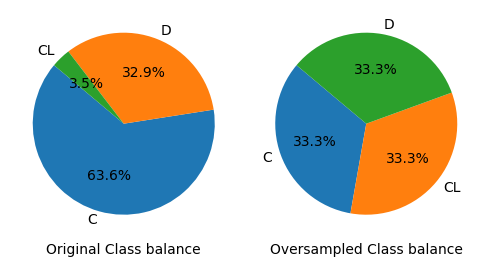

In [119]:
# Count the frequency of each category
category_counts = y_train.value_counts('Status')
category_counts_sm = y_sm.value_counts('Status')

# Draw a pie chart
fig, axes = plt.subplots(1,2, figsize=(5, 4))

category_counts.plot.pie(ax=axes[0], autopct='%1.1f%%', startangle=140)
category_counts_sm.plot.pie(ax=axes[1], autopct='%1.1f%%', startangle=140)

axes[0].set_ylabel('')
axes[1].set_ylabel('')
axes[0].set_xlabel('Original Class balance')
axes[1].set_xlabel('Oversampled Class balance')

plt.tight_layout()

In [120]:
# Train the model using the SMOTE oversampled dataset
model_smote = simple_model_for_testing(X_sm, y_sm)

# Make predictions on the test set
y_pred_smote = model_smote.predict(X_test)

# Output the performance metrics for the model trained on the SMOTE dataset
print("Classification report for the SMOTE dataset:")
SMOTE_report=classification_report(y_test, y_pred_smote)
print(SMOTE_report)

print("Confusion matrix for the SMOTE dataset:")
SMOTE_confusion_matrix=confusion_matrix(y_test, y_pred_smote)
print(SMOTE_confusion_matrix)

Classification report for the SMOTE dataset:
              precision    recall  f1-score   support

           C       0.83      0.77      0.80      1447
          CL       0.12      0.41      0.19        83
           D       0.73      0.64      0.68       842

    accuracy                           0.71      2372
   macro avg       0.56      0.61      0.56      2372
weighted avg       0.77      0.71      0.74      2372

Confusion matrix for the SMOTE dataset:
[[1118  145  184]
 [  29   34   20]
 [ 197  103  542]]


Oversampling Conclusion:
The SMOTE oversampling technique is effective in improving the recognition of minority classes, especially for the 'CL' class in this example. It enhances the model's recall rate for minority classes by increasing the number of minority class samples, though this may come at the cost of sacrificing some precision.
For dealing with imbalanced datasets, especially when aiming to improve the recognition of minority classes, SMOTE is a valuable tool. However, it is also important to be aware of potential overfitting and the possible impact on other classes when using oversampling techniques.

<h3>4.3 Weights</h3>

In [121]:
copy4_raw_train_data=full_raw_train_data.copy()
copy4_raw_test_data=raw_test_data_without_id.copy()

copy4_raw_train_data=copy4_raw_train_data.drop(['N_Days'], axis=1)
copy4_raw_test_data=copy4_raw_test_data.drop(['N_Days'], axis=1)


In [122]:
cat_train = copy4_raw_train_data.select_dtypes(include = ['object']).astype('category')

In [123]:
from sklearn.preprocessing import LabelEncoder

# Define mappings for each categorical variable
mapping_dicts = {
    'Drug': {'D-penicillamine': 0, 'Placebo': 1},
    'Sex': {'M': 0, 'F': 1},
    'Ascites': {'N': 0, 'Y': 1},
    'Hepatomegaly': {'N': 0, 'Y': 1},
    'Spiders': {'N': 0, 'Y': 1},
    'Edema': {'N': 0, 'Y': 1, 'S': 2},
    'Status': {'C': 0, 'CL': 1, 'D': 2},
}

# Create a LabelEncoder instance
le = LabelEncoder()

# Apply LabelEncoder to each column using a loop or list comprehension
for col, mapping in mapping_dicts.items():
    copy4_raw_train_data[col] = le.fit_transform(copy4_raw_train_data[col].map(mapping))


copy4_raw_train_data.head()    


Drug    Age  Sex  Ascites  Hepatomegaly  Spiders  Edema  Bilirubin  \
id                                                                       
0      0  21532    0        0             0        0      0        2.3   
1      1  19237    1        0             0        0      0        0.9   
2      1  13727    1        0             1        1      1        3.3   
3      1  18460    1        0             0        0      0        0.6   
4      1  16658    1        0             1        0      0        1.1   

    Cholesterol  Albumin  Copper  Alk_Phos    SGOT  Tryglicerides  Platelets  \
id                                                                             
0           316     3.35     172    1601.0  179.80             63        394   
1           364     3.54      63    1440.0  134.85             88        361   
2           299     3.55     131    1029.0  119.35             50        199   
3           256     3.50      58    1653.0   71.30             96        269   
4           346     3.65      63    1181.0  125.55             96        298   

    Prothrombin  Stage  Status  
id                              
0           9.7      3       2  
1          11.0      3       0  
2          11.7      4       2  
3          10.7      3       0  
4          10.6      4       0

In [124]:
integer_column=['Age','Cholesterol','Copper','Tryglicerides','Platelets','Stage']
categorical_column=['Drug','Sex','Ascites','Hepatomegaly','Spiders','Edema', 'Status']
float_column=['Bilirubin','Albumin','Alk_Phos','SGOT','Prothrombin']

for i in categorical_column:
    copy4_raw_train_data[i] = pd.Categorical(copy4_raw_train_data[i])

for i in integer_column:
    copy4_raw_train_data[i] = copy4_raw_train_data[i].astype('int64')

for i in float_column:
    copy4_raw_train_data[i] = copy4_raw_train_data[i].astype('float')

In [125]:
# Calculate the number of samples for each class in the training set
class_counts = copy4_raw_train_data['Status'].value_counts()

# Calculate the proportion of samples for each class in the training set
class_proportions = class_counts / len(copy4_raw_train_data)

# Calculate the weights for each class such that the class with fewer samples has a higher weight
class_weights = 1 / class_proportions

# Convert the weights to a dictionary format for use in the logistic regression model
class_weights_dict = {0: class_weights[0], 1: class_weights[1], 2: class_weights[2]}

print("Class Weights:", class_weights_dict)

Class Weights: {0: 1.5921450151057404, 1: 28.745454545454542, 2: 2.9662288930581613}


In [126]:
copy4_raw_train_data_y=copy4_raw_train_data['Status']
copy4_raw_train_data=copy4_raw_train_data.drop('Status', axis=1)

In [127]:
X_train, X_valid, y_train, y_valid = train_test_split(copy4_raw_train_data, copy4_raw_train_data_y, test_size=0.3, random_state=42)

In [128]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, log_loss

# Create a Random Forest Classifier object
tree_classifier = DecisionTreeClassifier(random_state=42, criterion='log_loss', min_samples_split=100)


# Use cross-validation for prediction
y_train_pred = cross_val_predict(tree_classifier, X_train, y_train, cv=5)

# Calculate accuracy on the training set
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Training set accuracy:", train_accuracy)

# Use cross-validation to predict class probabilities for each sample
y_train_pred_proba = cross_val_predict(tree_classifier, X_train, y_train, cv=5, method='predict_proba')

# Calculate log loss in cross-validation
cv_logloss = log_loss(y_train, y_train_pred_proba)
print("Cross-validation log loss:", cv_logloss)

Training set accuracy: 0.7775167178745708
Cross-validation log loss: 1.4366024202119057


In [129]:
# Create a Random Forest Classifier object with specified class weights
tree_classifier = DecisionTreeClassifier(random_state=42, criterion='log_loss', min_samples_split=100,
                                       class_weight={0: 2.9662288930581613, 1: 1.5921450151057404, 2: 28.745454545454542})

# Use cross-validation for prediction
y_train_pred = cross_val_predict(tree_classifier, X_train, y_train, cv=5)

# Calculate accuracy on the training set
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Training set accuracy:", train_accuracy)

# Use cross-validation to predict class probabilities for each sample
y_train_pred_proba = cross_val_predict(tree_classifier, X_train, y_train, cv=5, method='predict_proba')

# Calculate log loss in cross-validation
cv_logloss = log_loss(y_train, y_train_pred_proba)
print("Cross-validation log loss:", cv_logloss)

Training set accuracy: 0.6307608892101934
Cross-validation log loss: 1.7487684150461382


Log Loss score got worse so this weighting is incorrect. Next step is to attempt a range of weights.

In [130]:
from sklearn.model_selection import GridSearchCV

# Define the Random Forest Classifier
tree_classifier = DecisionTreeClassifier(random_state=42, criterion='log_loss', min_samples_split=100)

# Define the range of parameters to search
param_grid = {'class_weight': [{0: 2.0, 1: 1.0, 2: 1.5}, {0: 3.0, 1: 1.0, 2: 2.0}, {0: 1.0, 1: 1.0, 2: 1.0}]}

# Create a grid search object
grid_search = GridSearchCV(estimator=tree_classifier, param_grid=param_grid, cv=5, scoring='neg_log_loss')

# Perform grid search on the training data
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", -grid_search.best_score_)

Best Parameters: {'class_weight': {0: 3.0, 1: 1.0, 2: 2.0}}
Best Score: 1.3755013068308035


In [131]:
# Create the Random Forest Classifier with the best parameters
best_rf_classifier = DecisionTreeClassifier(random_state=42, criterion='log_loss', min_samples_split=100, 
                                             class_weight=grid_search.best_params_['class_weight'])

# Make predictions using cross-validation
y_train_pred = cross_val_predict(best_rf_classifier, X_train, y_train, cv=5)

# Calculate the accuracy on the training set
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Training Accuracy:", train_accuracy)

# Make predictions of class probabilities using cross-validation
y_train_pred_proba = cross_val_predict(best_rf_classifier, X_train, y_train, cv=5, method='predict_proba')

# Calculate the log loss in cross-validation
cv_logloss = log_loss(y_train, y_train_pred_proba)
print("Cross-Validation Log Loss:", cv_logloss)

Training Accuracy: 0.7829387312488704
Cross-Validation Log Loss: 1.3754422765814798


Logloss did decrease after adjusting different weights

In [132]:
best_rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred_smote = best_rf_classifier.predict(X_valid)

# Output the performance metrics for the model trained on the weighted dataset
print("Classification report for the best weight params dataset:")
weight_report=classification_report(y_valid, y_pred_smote)
print(weight_report)

print("Confusion matrix for the best weight params dataset:")
weight_confusion_matrix=confusion_matrix(y_valid, y_pred_smote)
print(weight_confusion_matrix)

Classification report for the best weight params dataset:
              precision    recall  f1-score   support

           0       0.77      0.93      0.85      1447
           1       0.33      0.01      0.02        83
           2       0.80      0.60      0.68       842

    accuracy                           0.78      2372
   macro avg       0.63      0.51      0.52      2372
weighted avg       0.77      0.78      0.76      2372

Confusion matrix for the best weight params dataset:
[[1347    0  100]
 [  54    1   28]
 [ 338    2  502]]


<h3>4.4 Comparing Methods</h3>

SMOTE:
Weight: 


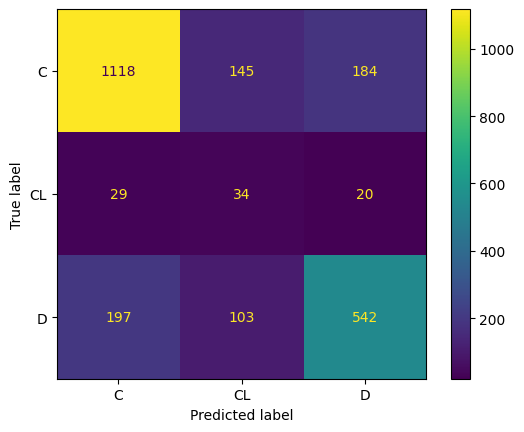

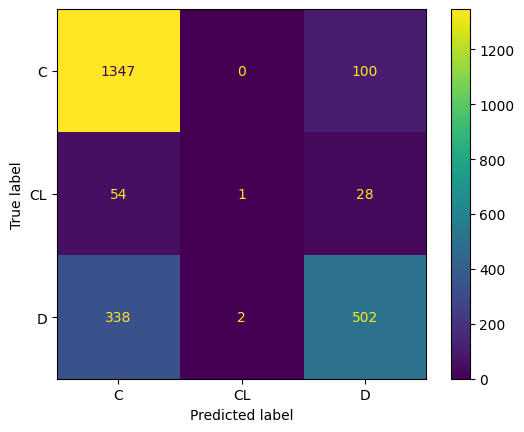

In [133]:
#SMOTE does a better job of improving the classification of class: 'CL'
print('SMOTE:')
smote_disp=ConfusionMatrixDisplay(SMOTE_confusion_matrix, display_labels=['C','CL','D'])
smote_disp.plot()
print('Weight: ')
weight_disp=ConfusionMatrixDisplay(weight_confusion_matrix, display_labels=['C','CL','D'])
weight_disp.plot()

SMOTE does a better job at predicting the class CL.

<h2>5. Testing Models</h2>

<h3>5.1 Gaussian Naive Bayes</h3>

In [134]:
cirrhosis_copy=full_raw_train_data.copy()

In [135]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler

# Encode categorical variables using one-hot encoding
encoder = OneHotEncoder(sparse_output=False)
encoded_features = encoder.fit_transform(cirrhosis_copy[['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema']])
encoded_features_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out())

# Label encode the response variable
le = LabelEncoder()
cirrhosis_copy['Status'] = le.fit_transform(cirrhosis_copy['Status'])


# Scale the numerical data
scaler = StandardScaler()
numeric_features_unscaled = cirrhosis_copy.select_dtypes(include=['int64', 'float64']).drop(['Status'], axis=1).reset_index(drop=True)
numeric_features=scaler.fit_transform(numeric_features_unscaled)
numeric_features=pd.DataFrame(numeric_features, index=numeric_features_unscaled.index, columns=numeric_features_unscaled.columns)



# Merge the encoded features with other numerical features
encoded_features_df = encoded_features_df.reset_index(drop=True)
scaled_features = pd.concat([numeric_features, encoded_features_df], axis=1)

# Split into training and test sets
X_train, X_valid, y_train, y_valid = train_test_split(scaled_features, cirrhosis_copy['Status'], test_size=0.3, random_state=42)

In [136]:
#first model: Bayes-GaussianNB
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import log_loss, mean_squared_error

# Initialize the GaussianNB classifier
gnb = GaussianNB()

# Fit the model using the training data
gnb.fit(X_train, y_train)

# Make predictions on the test set
y_pred = gnb.predict(X_valid)

# Calculate the accuracy
accuracy = accuracy_score(y_valid, y_pred)
print("Accuracy:", accuracy)

# Output the classification report
print(classification_report(y_valid, y_pred))

# Calculate the Log Loss
log_loss_score=log_loss(y_valid,gnb.predict_proba(X_valid))
print('LogLoss:', log_loss_score)

Accuracy: 0.718381112984823
              precision    recall  f1-score   support

           0       0.75      0.91      0.82      1447
           1       0.05      0.08      0.06        83
           2       0.81      0.44      0.57       842

    accuracy                           0.72      2372
   macro avg       0.54      0.48      0.49      2372
weighted avg       0.75      0.72      0.71      2372

LogLoss: 2.592006115177726


In [137]:
from sklearn.model_selection import GridSearchCV

# Define the model
gnb = GaussianNB()

# Define the range of parameters to search
param_grid = {'var_smoothing': np.logspace(0,-9, num=100)}

# Use cross-validation to search for the best parameters
grid_search = GridSearchCV(estimator=gnb, param_grid=param_grid, cv=5, scoring='neg_log_loss')

grid_search.fit(X_train, y_train)

# Output the best parameters
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

print("Log Loss", log_loss(y_valid, grid_search.predict_proba(X_valid)))

Best parameters: {'var_smoothing': 1.0}
Best score: -0.694543265872249
Log Loss 0.703287652484924


<h5>5.1.1 Gaussian Naive Bayes with SMOTE</h5>

In [138]:
warnings.filterwarnings("ignore", category=UserWarning)
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_sm, y_sm = smote.fit_resample(X_train, y_train )

# Define the model
gnb = GaussianNB()

# Define the range of parameters to search
param_grid = {'var_smoothing': np.logspace(0,-9, num=100)}

# Use cross-validation to search for the best parameters
grid_search = GridSearchCV(estimator=gnb, param_grid=param_grid, cv=5, scoring='neg_log_loss')

grid_search.fit(X_sm, y_sm)

# Output the best parameters
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

print("Log Loss", log_loss(y_valid, grid_search.predict_proba(X_valid)))

Best parameters: {'var_smoothing': 1.0}
Best score: -0.913576858457529
Log Loss 0.8959999120375646


When comparing gaussian NB models with and without SMOTE, the use of SMOTE improves worsens the log_loss score.

<h4>Aside:</h4> Gaussain NB didn't perform better with SMOTE however all the models below will use SMOTE.  

In [115]:
#Redefining variables to remove any confusion
X = full_raw_train_data.drop('Status', axis=1)
y = full_raw_train_data['Status']

X_encoded = pd.get_dummies(X, drop_first=True)
X_train, X_valid, y_train, y_valid = train_test_split(X_encoded, y, test_size=0.3, random_state=42)


from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_sm, y_sm = smote.fit_resample(X_train, y_train )

<h3>5.2 Random Forest Classifier</h3>

In [117]:
from sklearn.ensemble import RandomForestClassifier

rf_class = RandomForestClassifier(criterion="log_loss", min_samples_split=5, max_depth=30, min_samples_leaf=2, n_estimators=200)
rf_class.fit(X_sm, y_sm)
y_pred_rf = rf_class.predict(X_valid)
rf_report = classification_report(y_valid, y_pred_rf)
rf_confusion_matrix = confusion_matrix(y_valid, y_pred_rf)
print(rf_report)
print(rf_confusion_matrix)
print(log_loss(y_valid, rf_class.predict_proba(X_valid)))

              precision    recall  f1-score   support

           C       0.86      0.87      0.87      1447
          CL       0.26      0.29      0.27        83
           D       0.79      0.76      0.77       842

    accuracy                           0.81      2372
   macro avg       0.64      0.64      0.64      2372
weighted avg       0.81      0.81      0.81      2372

[[1265   42  140]
 [  33   24   26]
 [ 178   27  637]]
0.5059381769719482


<h3>5.3 SVM classifier</h3>

In [118]:
SVM_copy_df=full_raw_train_data.copy()

In [119]:
# Makes sure the features are the correct data type
integer_column=['N_Days','Age','Cholesterol','Copper','Tryglicerides','Platelets','Stage']
categorical_column=['Drug','Sex','Ascites','Hepatomegaly','Spiders','Edema']
float_column=['Bilirubin','Albumin','Alk_Phos','SGOT','Prothrombin']

for i in categorical_column:
    SVM_copy_df[i] = pd.Categorical(SVM_copy_df[i])

for i in integer_column:
    SVM_copy_df[i] = SVM_copy_df[i].astype('int64')

for i in float_column:
   SVM_copy_df[i] = SVM_copy_df[i].astype('float')

In [120]:
X_encoded = pd.get_dummies(SVM_copy_df, drop_first=True)

In [121]:
X_train, X_valid, y_train, y_valid= train_test_split(X_encoded,y , test_size=0.3, random_state=42)
smote = SMOTE(random_state=42)
X_sm, y_sm = smote.fit_resample(X_train, y_train)

In [122]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder

numerical_feature=['N_Days','Age','Bilirubin','Cholesterol','Albumin','Copper','Alk_Phos','SGOT','Tryglicerides','Platelets','Prothrombin']
categorical_feature=['Drug_Placebo','Sex_M','Ascites_Y','Hepatomegaly_Y','Spiders_Y','Edema_S','Edema_Y']
ordinal_feature=['Stage']

full_pipeline = ColumnTransformer([("numerical", StandardScaler(), numerical_feature),
                                   ('ordinal', OrdinalEncoder(),ordinal_feature)])


#full_pipeline = ColumnTransformer([("numerical", StandardScaler(), numerical_feature),
#                                   ("categorical", OneHotEncoder(sparse_output=False), categorical_feature),
#                                   ('ordinal', OrdinalEncoder(),ordinal_feature)])


full_pipeline.set_output(transform="pandas")



X_prepared_train = full_pipeline.fit_transform(X_sm)
X_prepared_valid= full_pipeline.transform(X_valid)

X_prepared_train= pd.concat([X_prepared_train,X_sm[categorical_feature]], axis=1)
X_prepared_valid= pd.concat([X_prepared_valid,X_valid[categorical_feature]], axis=1)

In [123]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.preprocessing import LabelBinarizer

le=LabelBinarizer()
y_prepared_train = le.fit_transform(y_sm)

y_prepared_valid=le.transform(y_valid)

In [125]:
from sklearn.metrics import precision_recall_curve
def pr_rc_th_comapre(axs,y_prepared_train, tr_prob):
    ''' Plots precision and recall against threshold
    '''
    precision_tr = dict()
    recall_tr = dict()
    th=dict()
    print('Threshold for equal precsion and recall')
    for i in range(3):
        precision_tr[i], recall_tr[i], th[i] = precision_recall_curve(y_prepared_train[:, i],
                                                            tr_prob[:, i])
        

        
        axs.plot(th[i], precision_tr[i][1:], label='Train: precsion {}'.format(i))
        axs.plot(th[i], recall_tr[i][1:], label='Train: recall {}'.format(i))

        equall_th_value=th[i][np.abs(recall_tr[i]-precision_tr[i]).argmin()]
        print('Class',i,':',equall_th_value)
        
    axs.set_xlabel("threshold")
    axs.legend(loc="best")
    axs.grid()

def pr_rc_curve(axs,y_prepared_train, y_prepared_valid, tr_prob, vl_prob):
    '''Plots precison recall curves for all the classes'''

    #------------adapted from https://stackoverflow.com/questions/56090541/how-to-plot-precision-and-recall-of-multiclass-classifier
    precision_tr = dict()
    recall_tr = dict()
    precision_vl = dict()
    recall_vl = dict()


    for i in range(3):
        precision_tr[i], recall_tr[i], _ = precision_recall_curve(y_prepared_train[:, i],
                                                            tr_prob[:, i])
        
        precision_vl[i], recall_vl[i], _ = precision_recall_curve(y_prepared_valid[:, i],
                                                        vl_prob[:, i])
        
        axs.plot(recall_tr[i], precision_tr[i], label='Train: class {}'.format(i))
        axs.plot(recall_vl[i], precision_vl[i], label='Valid: class {}'.format(i), ls='dashed')
        
        
    axs.set_xlabel("recall")
    axs.set_ylabel("precision")
    axs.legend(loc="best")
    #------------------------------------------------------------------

<h4>Baseline</h4>

In [126]:
from sklearn.svm import SVC

svm_clf = OneVsRestClassifier(SVC(kernel='rbf'))
svm_clf.fit(X_prepared_train, y_prepared_train) 

OneVsRestClassifier(estimator=SVC())

Threshold for equal precsion and recall
Class 0 : -0.16964469199576104
Class 1 : 0.1303780036534432
Class 2 : -0.5301848864092737
['C' 'CL' 'D']


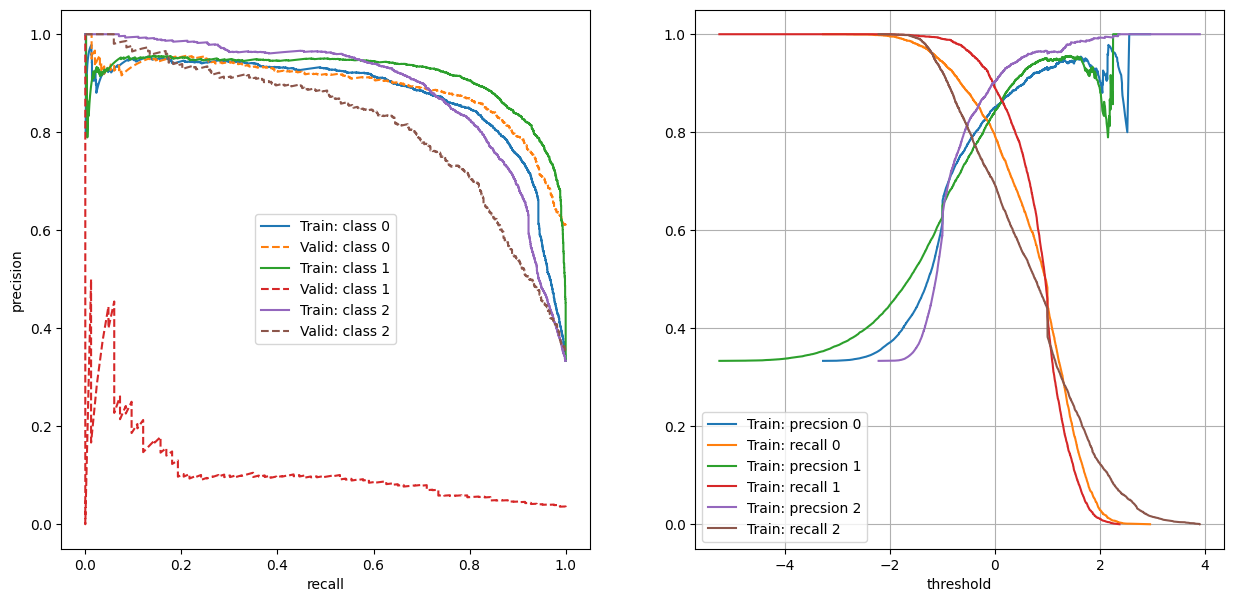

In [127]:
fig, axs=plt.subplots(1,2, figsize=[15,7])

tr_prob=svm_clf.decision_function(X_prepared_train)
vl_prob=svm_clf.decision_function(X_prepared_valid)
pr_rc_curve(axs[0],y_prepared_train,y_prepared_valid,tr_prob, vl_prob)
pr_rc_th_comapre(axs[1],y_prepared_train,tr_prob)
print(le.classes_)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for SVC using oversampled data 
              precision    recall  f1-score   support

           0       0.87      0.78      0.83      1447
           1       0.10      0.22      0.14        83
           2       0.83      0.64      0.72       842

   micro avg       0.80      0.71      0.75      2372
   macro avg       0.60      0.55      0.56      2372
weighted avg       0.83      0.71      0.77      2372
 samples avg       0.70      0.71      0.71      2372



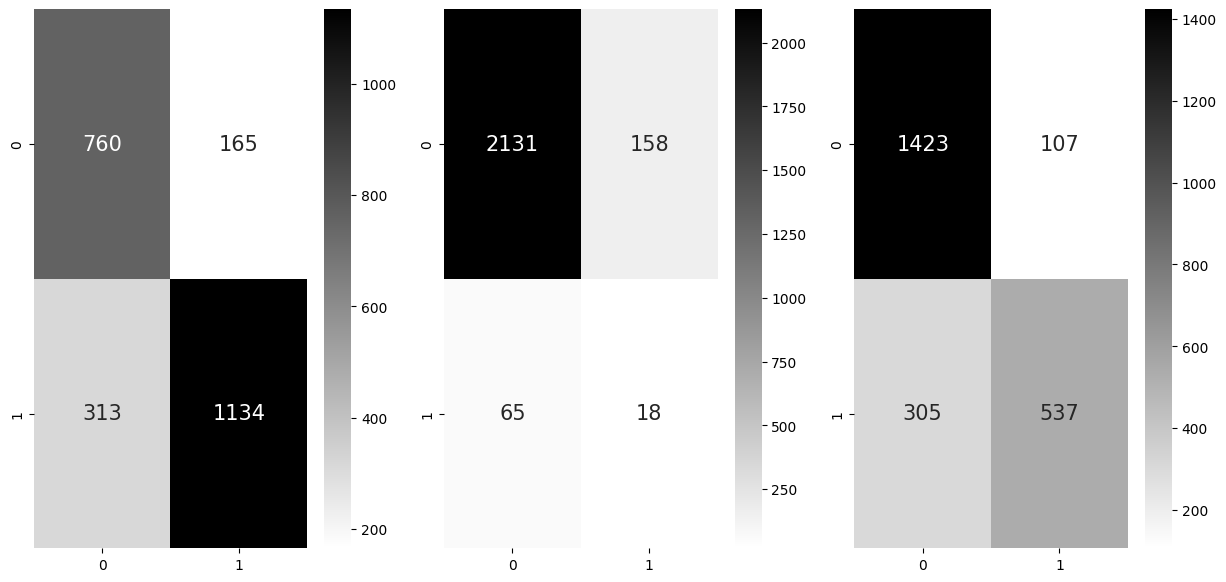

In [128]:
from sklearn.metrics import classification_report, confusion_matrix
validation_prediction_svc = svm_clf.predict(X_prepared_valid)
svc_report=classification_report(y_prepared_valid, validation_prediction_svc)
print("Classification report for SVC using oversampled data ")
print(svc_report)
matrix=multilabel_confusion_matrix(y_prepared_valid, validation_prediction_svc, labels=[0,1,2])

fig,ax=plt.subplots(1,3, figsize=(15,7))
for i in range(3):
    sns.heatmap(matrix[i], annot=True, fmt='d', cmap='binary', annot_kws={"fontsize":15}, ax=ax[i])

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


log_loss: 5.9962332582503


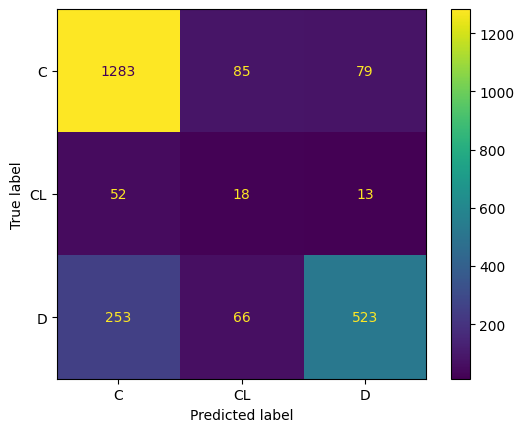

In [129]:
inverse_transform_y_valid=le.inverse_transform(y_prepared_valid)
inverse_transform_prediction=le.inverse_transform(validation_prediction_svc)

full_matrix=confusion_matrix(inverse_transform_y_valid,inverse_transform_prediction)
disp=ConfusionMatrixDisplay(full_matrix, display_labels=le.classes_)
disp.plot()

print('log_loss:',log_loss(le.inverse_transform(y_prepared_valid),vl_prob ))

Currently predicts too many instances as alive.

<h4>Tuning: Attempt 1</h4>

In [130]:
svm_clf_1 = SVC()
svm_clf_1.fit(X_prepared_train, le.inverse_transform(y_prepared_train)) 

SVC()

In [131]:
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.1, 1, 10],
              'gamma': ['scale', 'auto'],
              'kernel': ['rbf', 'linear']}
 
grid_search = GridSearchCV(svm_clf_1, param_grid, cv=2)
 
grid_search.fit(X_prepared_train, le.inverse_transform(y_prepared_train))
 
print(f"Best parameters:\n{grid_search.best_params_}")
 
best_model = grid_search.best_estimator_

Best parameters:
{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


Classification report for SVC using oversampled data 
              precision    recall  f1-score   support

           C       0.83      0.83      0.83      1447
          CL       0.12      0.22      0.15        83
           D       0.75      0.68      0.72       842

    accuracy                           0.76      2372
   macro avg       0.57      0.58      0.57      2372
weighted avg       0.78      0.76      0.77      2372



/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


log_loss: 2.7384394826787193


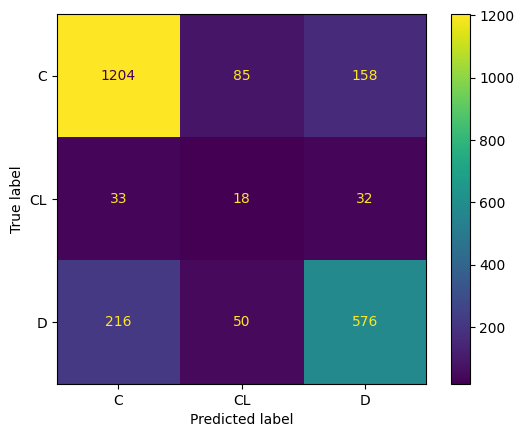

In [132]:
validation_prediction_svc = best_model.predict(X_prepared_valid)
svc_report=classification_report(le.inverse_transform(y_prepared_valid), validation_prediction_svc)
print("Classification report for SVC using oversampled data ")
print(svc_report)


inverse_transform_y_valid=le.inverse_transform(y_prepared_valid)


full_matrix=confusion_matrix(inverse_transform_y_valid,validation_prediction_svc)
disp=ConfusionMatrixDisplay(full_matrix, display_labels=le.classes_)
disp.plot()

print('log_loss:',log_loss(le.inverse_transform(y_prepared_valid),best_model.decision_function(X_prepared_valid) ))

<h4>Tuning: Attempt 2</h4>

Best parameters:
{'C': 20, 'gamma': 0.1, 'kernel': 'rbf'}
Classification report for SVC using oversampled data 
              precision    recall  f1-score   support

           C       0.82      0.85      0.83      1447
          CL       0.13      0.17      0.14        83
           D       0.74      0.68      0.71       842

    accuracy                           0.76      2372
   macro avg       0.56      0.57      0.56      2372
weighted avg       0.77      0.76      0.77      2372



/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


log_loss: 2.5147703892127913


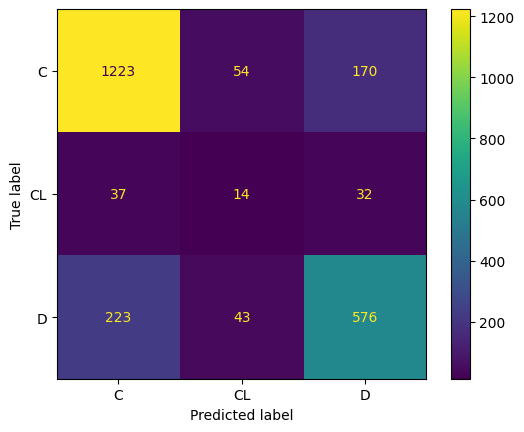

In [133]:
svm_clf_2 = SVC()
svm_clf_2.fit(X_prepared_train, le.inverse_transform(y_prepared_train)) 
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [5, 10, 15, 20],
              'gamma': ['scale', 0.1, 1, 10],
              'kernel': ['rbf']}
 
grid_search = GridSearchCV(svm_clf_2, param_grid, cv=2)
 
grid_search.fit(X_prepared_train, le.inverse_transform(y_prepared_train))
 
print(f"Best parameters:\n{grid_search.best_params_}")
 
best_model = grid_search.best_estimator_
validation_prediction_svc = best_model.predict(X_prepared_valid)
svc_report=classification_report(le.inverse_transform(y_prepared_valid), validation_prediction_svc)
print("Classification report for SVC using oversampled data ")
print(svc_report)


inverse_transform_y_valid=le.inverse_transform(y_prepared_valid)


full_matrix=confusion_matrix(inverse_transform_y_valid,validation_prediction_svc)
disp=ConfusionMatrixDisplay(full_matrix, display_labels=le.classes_)
disp.plot()

print('log_loss:',log_loss(inverse_transform_y_valid,best_model.decision_function(X_prepared_valid) ))

<h4>Tuning: Attempt 3</h4>

Best parameters:
{'C': 8, 'gamma': 0.5, 'kernel': 'rbf'}
Classification report for SVC using oversampled data 
              precision    recall  f1-score   support

           C       0.85      0.79      0.82      1447
          CL       0.15      0.11      0.13        83
           D       0.68      0.78      0.73       842

    accuracy                           0.76      2372
   macro avg       0.56      0.56      0.56      2372
weighted avg       0.77      0.76      0.76      2372



/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


log_loss: 2.1199206070965544


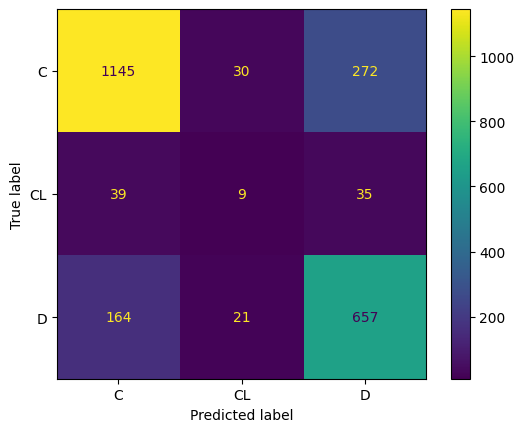

In [134]:
svm_clf_3 = SVC()
svm_clf_3.fit(X_prepared_train, le.inverse_transform(y_prepared_train)) 
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [8,10,12],
              'gamma': ['scale', 0.0005,0.05,0.1,0.5,],
              'kernel': ['rbf']}
 
grid_search = GridSearchCV(svm_clf_3, param_grid, cv=2)
 
grid_search.fit(X_prepared_train, le.inverse_transform(y_prepared_train))
 
print(f"Best parameters:\n{grid_search.best_params_}")
 
best_model = grid_search.best_estimator_
validation_prediction_svc = best_model.predict(X_prepared_valid)
svc_report=classification_report(le.inverse_transform(y_prepared_valid), validation_prediction_svc)
print("Classification report for SVC using oversampled data ")
print(svc_report)


inverse_transform_y_valid=le.inverse_transform(y_prepared_valid)


full_matrix=confusion_matrix(inverse_transform_y_valid,validation_prediction_svc)
disp=ConfusionMatrixDisplay(full_matrix, display_labels=le.classes_)
disp.plot()

print('log_loss:',log_loss(inverse_transform_y_valid,best_model.decision_function(X_prepared_valid) ))

Attempts at tuning the model do reduce the overclassification of status 'C' however it increases the overclassification of status 'D' patients and consequently makes the prediction of 'CL' patients worse. While the log loss score is better, overall the SVM classifier is not a good model to continue using when compared to the other models. 

<h3>5.4 Gradient Boosting Classifier</h3>

In [212]:
from sklearn.ensemble import GradientBoostingClassifier

# Split the data into features (X) and target variable (y)
X = full_raw_train_data.drop("Status", axis=1)
y = full_raw_train_data['Status']

# Split the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

print("train:", len(X_train), len(y_train))
print("valid:", len(X_valid), len(y_valid))
# Define numerical, categorical, and ordinal features
numerical_features = ['N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin']
categorical_features = ['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema']
ordinal_features = ['Stage']

# Define the full pipeline
full_pipeline = ColumnTransformer([
    ('numerical', StandardScaler(), numerical_features),
    ('categorical', OneHotEncoder(drop='first'), categorical_features),
    ('ordinal', OrdinalEncoder(), ordinal_features)  # Add OrdinalEncoder for ordinal features
])

# Fit and transform the training data
X_train_preprocessed = full_pipeline.fit_transform(X_train)

# Transform the validation data
X_valid_preprocessed = full_pipeline.transform(X_valid)

# Use SMOTE to oversample the training data
smote = SMOTE(random_state=242)
X_sm_train, y_sm_train = smote.fit_resample(X_train_preprocessed, y_train)

# Initialize the Gradient Boosting Classifier
gradient_boosting_model = GradientBoostingClassifier()

# Fit the model on the oversampled training set
gradient_boosting_model.fit(X_sm_train, y_sm_train)

# Make predictions on the validation set
valid_predictions = gradient_boosting_model.predict(X_valid_preprocessed)

# Output performance metrics for the validation set
print("Classification report for the validation set:")
valid_report = classification_report(y_valid, valid_predictions)
print(valid_report)

# Output the confusion matrix for the validation set
print("Confusion matrix for the validation set:")
valid_confusion_matrix = confusion_matrix(y_valid, valid_predictions)
print(valid_confusion_matrix)

# Make predictions on the validation set probabilities
valid_probabilities = gradient_boosting_model.predict_proba(X_valid_preprocessed)

# Calculate log loss for the validation set
valid_log_loss = log_loss(y_valid, valid_probabilities)
print("Log Loss for the validation set:", valid_log_loss)


train: 5533 5533
valid: 2372 2372


Classification report for the validation set:
              precision    recall  f1-score   support

           C       0.86      0.85      0.85      1447
          CL       0.19      0.36      0.25        83
           D       0.79      0.74      0.77       842

    accuracy                           0.79      2372
   macro avg       0.62      0.65      0.62      2372
weighted avg       0.81      0.79      0.80      2372

Confusion matrix for the validation set:
[[1231   73  143]
 [  34   30   19]
 [ 169   51  622]]
Log Loss for the validation set: 0.5194793670814797


In [213]:
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV

# Define the parameter grid for random search
param_grid = {
    'n_estimators': randint(50, 200),  # Number of trees in the forest
    'learning_rate': [0.001, 0.01, 0.1],  # Learning rate
    'max_depth': randint(3, 10),  # Maximum depth of the individual trees
    'min_samples_split': randint(2, 20),  # Minimum number of samples required to split an internal node
    'min_samples_leaf': randint(1, 20),  # Minimum number of samples required to be at a leaf node
}

# Initialize the RandomizedSearchCV object
random_search = RandomizedSearchCV(estimator=GradientBoostingClassifier(random_state=42), 
                                   param_distributions=param_grid, 
                                   n_iter=50,  # Number of parameter settings that are sampled
                                   scoring='neg_log_loss',  # Scoring method
                                   cv=3,  # Number of folds in cross-validation
                                   verbose=2,  # Controls the verbosity: the higher, the more messages
                                   n_jobs=-1)  # Number of jobs to run in parallel (-1 means using all processors)

# Perform the random search on the oversampled training data
random_search.fit(X_sm_train, y_sm_train)

# Print the best parameters found
print("Best parameters found by random search:", random_search.best_params_)

# Use the best model to make predictions on the validation set
best_model = random_search.best_estimator_
valid_predictions_random_search = best_model.predict(X_valid_preprocessed)

# Output performance metrics for the validation set using the best model found
print("Classification report for the validation set using the best model found:")
valid_report_random_search = classification_report(y_valid, valid_predictions_random_search)
print(valid_report_random_search)

# Output the confusion matrix for the validation set using the best model found
print("Confusion matrix for the validation set using the best model found:")
valid_confusion_matrix_random_search = confusion_matrix(y_valid, valid_predictions_random_search)
print(valid_confusion_matrix_random_search)

# Make predictions on the validation set probabilities using the best model found
valid_probabilities_random_search = best_model.predict_proba(X_valid_preprocessed)

# Calculate log loss for the validation set using the best model found
valid_log_loss_random_search = log_loss(y_valid, valid_probabilities_random_search)
print("Log Loss for the validation set using the best model found:", valid_log_loss_random_search)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[CV] END learning_rate=0.01, max_depth=4, min_samples_leaf=18, min_samples_split=10, n_estimators=94; total time=  43.2s
[CV] END learning_rate=0.01, max_depth=4, min_samples_leaf=18, min_samples_split=10, n_estimators=94; total time=  22.4s
[CV] END learning_rate=0.001, max_depth=6, min_samples_leaf=12, min_samples_split=4, n_estimators=174; total time= 1.3min
[CV] END learning_rate=0.001, max_depth=6, min_samples_leaf=12, min_samples_split=4, n_estimators=174; total time= 1.4min
[CV] END learning_rate=0.001, max_depth=6, min_samples_leaf=12, min_samples_split=4, n_estimators=174; total time= 1.4min
[CV] END learning_rate=0.01, max_depth=4, min_samples_leaf=18, min_samples_split=10, n_estimators=94; total time=  21.4s
[CV] END learning_rate=0.1, max_depth=4, min_samples_leaf=9, min_samples_split=16, n_estimators=54; total time=  15.3s
[CV] END learning_rate=0.1, max_depth=4, min_samples_leaf=9, min_samples_split=16, n_estimators=54; total time=  13.3s
[CV] END learning_rate=0.1, max_d

Best parameters found by random search: {'learning_rate': 0.1, 'max_depth': 8, 'min_samples_leaf': 12, 'min_samples_split': 9, 'n_estimators': 120}
After adjusting the hyperparameters the logloss had slight improvment going from 0.51947 to 0.51845. 


<h3>5.5 XGBoost (Regularised Gradient Boosting )</h3>

In [139]:
#Redefining variables to remove any confusion
X = full_raw_train_data.drop('Status', axis=1)
y = full_raw_train_data['Status']

X_encoded = pd.get_dummies(X, drop_first=True)
X_train, X_valid, y_train, y_valid = train_test_split(X_encoded, y, test_size=0.3, random_state=42)

smote = SMOTE(random_state=42)
X_sm, y_sm = smote.fit_resample(X_train, y_train )

In [140]:
le_2=LabelEncoder()
y_sm_le=le_2.fit_transform(y_sm)

In [141]:
# Initialize the XGBoost classifier
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

# Train the model
xgb_clf.fit(X_sm, y_sm_le)

# Make predictions on the test set
y_pred = xgb_clf.predict(X_valid)

print(le_2.classes_)

# Calculate accuracy
accuracy = accuracy_score(le_2.transform(y_valid), y_pred)
print("Accuracy with XGBoost:", accuracy)

# Output the classification report
print(classification_report(le_2.transform(y_valid), y_pred))


y_pred_proba = xgb_clf.predict_proba(X_valid)
# Calculate the Log Loss
log_loss_value_xgb = log_loss(le_2.transform(y_valid), y_pred_proba)
print("Log Loss with XGBoost:", log_loss_value_xgb)

['C' 'CL' 'D']
Accuracy with XGBoost: 0.8149241146711635
              precision    recall  f1-score   support

           0       0.85      0.88      0.87      1447
           1       0.26      0.24      0.25        83
           2       0.80      0.75      0.77       842

    accuracy                           0.81      2372
   macro avg       0.64      0.63      0.63      2372
weighted avg       0.81      0.81      0.81      2372

Log Loss with XGBoost: 0.5400290990619893


In [142]:
print(xgb_clf.get_params())

{'objective': 'multi:softprob', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': 'mlogloss', 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 42, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None, 'use_label_encoder': False}


In [143]:
#tune the model

# Define the data matrix
dtrain = xgb.DMatrix(X_sm, label=y_sm_le)

# Define model parameters
params = {
    'objective': 'multi:softprob',  # Objective for multi-classification
    'num_class': 3,  # Number of classes, match it with your dataset
    'eval_metric': 'mlogloss',  # Evaluation metric
    'learning_rate': 0.1,  # Learning rate
    'max_depth': 6,  # Maximum depth of the trees
    'subsample': 0.8,  # Subsample ratio of the training instances
    'colsample_bytree': 0.8,  # Subsample ratio of columns when constructing each tree
}



# Perform cross-validation
cv_results = xgb.cv(dtrain=dtrain, params=params, nfold=3, num_boost_round=50, 
                    early_stopping_rounds=10, metrics="mlogloss", as_pandas=True, seed=42)


# Print the score

print(f"Best mlogloss Score: {cv_results['test-mlogloss-mean'].min()}")


Best mlogloss Score: 0.4250365220333605


In [144]:
# Initialize the XGBoost classifier using parameters from above
xgb_clf_2 = xgb.XGBClassifier(objective='multi:softprob',num_class= 3,eval_metric='mlogloss',learning_rate=0.1,max_depth=6,subsample=0.8,colsample_bytree=0.8,random_state=42)

# Train the model
xgb_clf_2.fit(X_sm, y_sm_le)

y_pred = xgb_clf_2.predict(X_valid)
y_pred_proba = xgb_clf_2.predict_proba(X_valid)
# Calculate the Log Loss
log_loss_value_xgb = log_loss(le_2.transform(y_valid), y_pred_proba)
print("Log Loss with XGBoost:", log_loss_value_xgb)

print(classification_report(le_2.transform(y_valid), y_pred))

Log Loss with XGBoost: 0.5006611077616914
              precision    recall  f1-score   support

           0       0.86      0.86      0.86      1447
           1       0.23      0.34      0.28        83
           2       0.79      0.75      0.77       842

    accuracy                           0.80      2372
   macro avg       0.63      0.65      0.64      2372
weighted avg       0.81      0.80      0.81      2372



<h3>5.6 Logistic Regressor</h3>

In [141]:
df_train_raw=full_raw_train_data.copy()

In [142]:
integer_column=['Age','Cholesterol','Copper','Tryglicerides','Platelets','Stage']
categorical_column=['Drug','Sex','Ascites','Hepatomegaly','Spiders','Edema', 'Status']
float_column=['Bilirubin','Albumin','Alk_Phos','SGOT','Prothrombin'] 


le_3 = LabelEncoder()

for col in categorical_column:
    df_train_raw[col] = df_train_raw[col].astype(str) # Convert to string to ensure consistency
    df_train_raw[col] = le_3.fit_transform(df_train_raw[col])

In [143]:
X = df_train_raw.drop(['Status'], axis=1)
y = df_train_raw['Status']

# Splitting the data first 
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)


# Then resample
smote = SMOTE()
X_res, y_res = smote.fit_resample(X_train, y_train)

In [144]:
from sklearn.linear_model import LogisticRegression

# Logistic Regression model
log_reg = LogisticRegression(multi_class='multinomial', max_iter=1000)
log_reg.fit(X_res, y_res)

# Predictions
predictions = log_reg.predict(X_valid)
prob_predictions = log_reg.predict_proba(X_valid)

# Evaluation
print(classification_report(y_valid, predictions))
loss = log_loss(y_valid, prob_predictions)
print(f"Log Loss: {loss}")

              precision    recall  f1-score   support

           0       0.83      0.72      0.77      1447
           1       0.08      0.47      0.14        83
           2       0.72      0.57      0.64       842

    accuracy                           0.66      2372
   macro avg       0.55      0.59      0.52      2372
weighted avg       0.77      0.66      0.70      2372

Log Loss: 0.8586130196483918


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


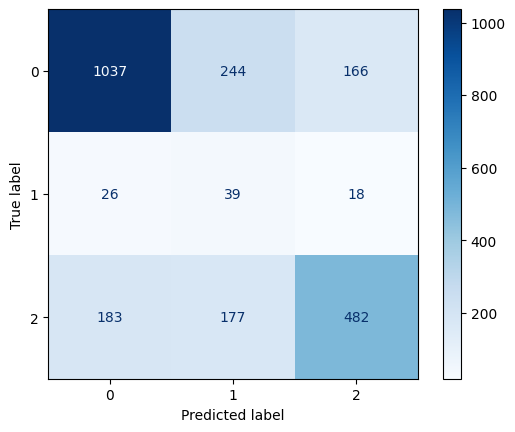

In [145]:
# Calculating confusion matrix
cm = confusion_matrix(y_valid, predictions)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_reg.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [146]:
from sklearn.feature_selection import RFE

# RFE with logistic regression for multiclass
rfe = RFE(estimator=LogisticRegression(max_iter=1000, multi_class='multinomial'), n_features_to_select=1)
rfe.fit(X_train, y_train)

# Summarizing the ranking of the features
ranking_rfe = pd.DataFrame({'Feature': X_train.columns, 'Ranking': rfe.ranking_}).sort_values(by="Ranking")

print(ranking_rfe)


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

          Feature  Ranking
4         Ascites        1
5    Hepatomegaly        2
7           Edema        3
10        Albumin        4
3             Sex        5
6         Spiders        6
16    Prothrombin        7
17          Stage        8
1            Drug        9
8       Bilirubin       10
13           SGOT       11
11         Copper       12
15      Platelets       13
14  Tryglicerides       14
9     Cholesterol       15
0          N_Days       16
2             Age       17
12       Alk_Phos       18


In [147]:
# Averaging the absolute values of coefficients across all classes
importance = np.mean(np.abs(log_reg.coef_), axis=0)

# Matching each averaged importance score with its corresponding feature name
feature_importance = pd.DataFrame(importance, index=X_train.columns, columns=["Importance"])

# Sorting the features by their importance
feature_importance_sorted = feature_importance.sort_values(by="Importance", ascending=False)

print(feature_importance_sorted)

               Importance
Bilirubin        0.103297
Prothrombin      0.029844
Albumin          0.024603
Hepatomegaly     0.014269
Edema            0.013595
Drug             0.013158
Stage            0.010454
Spiders          0.008676
Copper           0.004308
SGOT             0.004151
Ascites          0.004096
Sex              0.003532
Platelets        0.003040
Tryglicerides    0.001828
Cholesterol      0.000501
N_Days           0.000250
Age              0.000054
Alk_Phos         0.000042


<h4>5.6.1 Removing less important features</h4>

In [148]:
feature_to_drop=['Cholesterol', 'Age', 'Alk_Phos','N_Days']
X_res_new_features=X_res.drop(feature_to_drop, axis=1)
X_valid_new_features=X_valid.drop(feature_to_drop, axis=1)

In [149]:
# Logistic Regression model
log_reg = LogisticRegression(multi_class='multinomial', max_iter=1000)
log_reg.fit(X_res_new_features, y_res)

# Predictions
predictions = log_reg.predict(X_valid_new_features)
prob_predictions = log_reg.predict_proba(X_valid_new_features)

# Evaluation
print(classification_report(y_valid, predictions))
loss = log_loss(y_valid, prob_predictions)
print(f"Log Loss: {loss}")


              precision    recall  f1-score   support

           0       0.83      0.76      0.80      1447
           1       0.08      0.31      0.12        83
           2       0.76      0.65      0.70       842

    accuracy                           0.70      2372
   macro avg       0.56      0.57      0.54      2372
weighted avg       0.78      0.70      0.74      2372

Log Loss: 0.8091920930875935


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


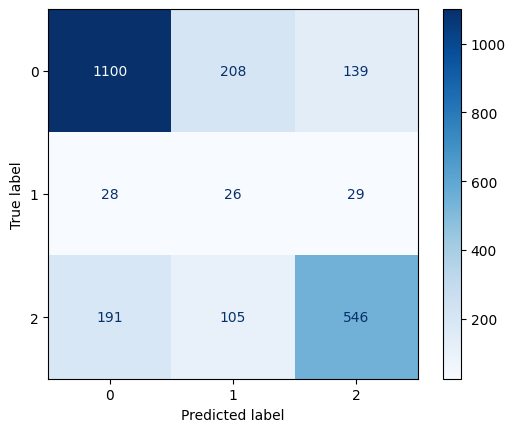

In [150]:
cm = confusion_matrix(y_valid, predictions)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_reg.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

<h2>6. Conclusion</h2>

|Model|Best LogLoss Score~|Parameters used|
|---|---|---|
|XGBoost|0.5006611077616914|objective='multi:softprob',num_class= 3,eval_metric='mlogloss',learning_rate=0.1,max_depth=6,subsample=0.8,colsample_bytree=0.8,random_state=42|
|Random Forest |0.5059381769719482|criterion="log_loss", min_samples_split=5, max_depth=30, min_samples_leaf=2, n_estimators=200|
|Gradient Boosting|0.5184596433721362|learning_rate=0.1, max_depth=8, min_samples_leaf=12, min_samples_split=9, n_estimator=120|
|Gaussian NB|0.703287652484924|var_smoothing= 1.0|
|Logistic Regressor|0.8091920930875935|multi_class='multinomial', max_iter=1000|
|SVM|2.1199206070965544|C= 8, gamma= 0.5, kernel= 'rbf'|

<h3>6.1 Apply Final Model to test set </h3>

In [149]:
#Redefining variables to remove any confusion
X = full_raw_train_data.drop('Status', axis=1)
y = full_raw_train_data['Status']

trainANDtest=pd.concat([X,raw_test_data_without_id],axis=0)
X_encode_trainANDTest=pd.get_dummies(trainANDtest, drop_first=True)
X_encoded=X_encode_trainANDTest[:len(X)]
X_test=X_encode_trainANDTest[len(X):]

X_train, X_valid, y_train, y_valid = train_test_split(X_encoded, y, test_size=0.3, random_state=42)

smote = SMOTE(random_state=42)
X_sm, y_sm = smote.fit_resample(X_train, y_train )
le_2=LabelEncoder()
y_sm_le=le_2.fit_transform(y_sm)

# Initialize the XGBoost classifier using parameters from above
xgb_clf_final = xgb.XGBClassifier(objective='multi:softprob',num_class= 3,eval_metric='mlogloss',learning_rate=0.1,max_depth=6,subsample=0.8,colsample_bytree=0.8,random_state=42)

# Train the model
xgb_clf_final.fit(X_sm, y_sm_le)

y_pred_proba = xgb_clf_final.predict_proba(X_valid)
# Calculate the Log Loss
log_loss_value_xgb = log_loss(le_2.transform(y_valid), y_pred_proba)
print("Log Loss with XGBoost:", log_loss_value_xgb)

Log Loss with XGBoost: 0.4811799856525267


In [150]:
# Use the fitted model to predict probabilities for the test data
test_probabilities = xgb_clf_final.predict_proba(X_test)

# Create a submission DataFrame
submission = pd.DataFrame({
    "id": raw_test_data_with_id["id"],                  # ID column of the test data
    "Status_C": test_probabilities[:, 0],       # Predicted probabilities for class C
    "Status_CL": test_probabilities[:, 1],      # Predicted probabilities for class CL
    "Status_D": test_probabilities[:, 2]        # Predicted probabilities for class D
})

# Save the submission file as a CSV format
submission.to_csv("submission.csv", index=False)

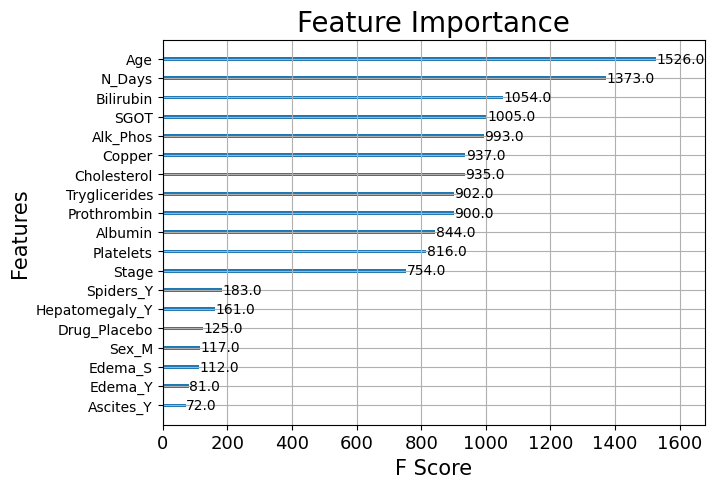

In [153]:
from xgboost import plot_importance

fig, ax = plt.subplots(figsize=(7, 5))
xgb.plot_importance(xgb_clf_final, ax=ax)
ax.set_xlabel('F Score', fontsize=15)
ax.set_ylabel('Features', fontsize=15)
ax.set_title('Feature Importance', fontsize=20)
ax.tick_params(axis='x', which='major', labelsize=13)

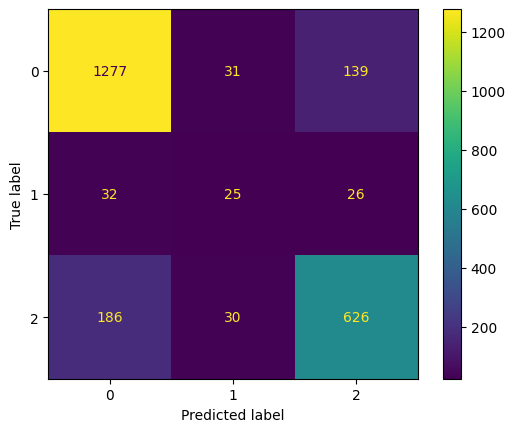

In [159]:
valid_predictions_final=xgb_clf_final.predict(X_valid)
final_matrix=confusion_matrix(y_valid,le_2.inverse_transform(valid_predictions_final))
final_disp=ConfusionMatrixDisplay(final_matrix, display_labels=['C','Cl','D'])
final_disp.plot()